# Stations Sensirion
**Purpose:** Analyze the *results*, *random error*, and *systematic error* for the Sensirion sensors used during measurement of air pollution on the Stockholm subway platforms.

### Structure

**Results**

* What is the mean air pollution for each station?
* What is the difference between morning and afternoon?
* Compare during rush hour and off-hour
* How does these values relate to the WHO Guidelines?
* General statistics of measuring time

**Random error**

* Look at distributions
* Look at standard deviations
* Anova

**Systematic error**

* Drift
* How much systematic error would we need to have for an "acceptable value" to be what we observe?


## Setup

In [250]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
# Read Session df, and raw session df
s_df = pd.read_csv('../results/sessions/sensirion.csv')
r_df = pd.read_csv('../results/sessions/sensirion_raw.csv')

# Convert sensor column to string
r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep stations from the green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# Sort by green line
green_line_order = CategoricalDtype(get_green_line(), ordered=True)

s_df['Station Order'] = s_df['Station'].astype(green_line_order)
r_df['Station Order'] = r_df['Station'].astype(green_line_order)

s_df = s_df.sort_values('Station Order')
r_df = r_df.sort_values('Station Order')

# Morning and evening
def morning(x):
    return ((x > '06:00:00') & (x < '09:00:00'))
    
def evening(x):
    return ((x > '15:00:00') & (x < '18:00:00'))
    
s_df['Period'] = s_df['Time'].apply(lambda x: 'Morning rush' if morning(x) else 'Evening rush' if evening(x) else 'Offtime')

# Keep a record of station id's
session_ids = sorted(list(r_df["Session Id"].unique()))

# Choose what param to be analyzed
param = 'PM2.5'
unit = 'µg/m³'

# figure folder
fig_folder = '../results/stations_sensirion'

## Overview Statistics

### Number of sessions

**Key stats:**

Total sessions: 38

Most sessions: Odenplan, 27

Least sessions: Ängbyplan, 2

In [252]:
### Sessions per station
def total_count(x):
    return len(x)

def morning_rush_count(x):
    return x.value_counts()['Morning rush']

def evening_rush_count(x):
    return x.value_counts()['Evening rush']

def offtime_count(x):
    if 'Offtime' not in x.values:
        return 0
        
    return x.value_counts()['Offtime']

session_count = s_df.groupby('Station').agg({'Period': [total_count, morning_rush_count, evening_rush_count, offtime_count]})

print(f'Total unique sessions: {len(s_df["Session Id"].unique())}')

session_count = session_count['Period'].sort_values(by='total_count', ascending=False)
session_count.loc['Total'] = session_count.sum()

session_count.to_csv(f'{fig_folder}/tables/session_counts({param}).csv')

session_count


Total unique sessions: 38


total_count  morning_rush_count  evening_rush_count  \
Station                                                                 
Odenplan                   27                  12                   9   
St Eriksplan               20                   8                   8   
Fridhemsplan               20                   8                   8   
Kristineberg               20                   8                   7   
Alvik                      20                   8                   7   
Slussen                    18                   9                   5   
Medborgarplatsen           17                   9                   5   
Thorildsplan               17                   6                   6   
T-Centralen                17                   8                   5   
Gamla Stan                 17                   9                   5   
Rådmansgatan               17                   8                   5   
Skanstull                  17                   9                   5   
Gullmarsplan               16                   8                   5   
Hötorget                   16                   7                   5   
Stora mossen               11                   3                   6   
Abrahamsberg               11                   3                   5   
Brommaplan                 11                   3                   5   
Åkeshov                     9                   2                   3   
Islandstorget               4                   2                   1   
Angbyplan                   2                   1                   1   
Total                     307                 131                 106   

                  offtime_count  
Station                          
Odenplan                      6  
St Eriksplan                  4  
Fridhemsplan                  4  
Kristineberg                  5  
Alvik                         5  
Slussen                       4  
Medborgarplatsen              3  
Thorildsplan                  5  
T-Centralen                   4  
Gamla Stan                    3  
Rådmansgatan                  4  
Skanstull                     3  
Gullmarsplan                  3  
Hötorget                      4  
Stora mossen                  2  
Abrahamsberg                  3  
Brommaplan                    3  
Åkeshov                       4  
Islandstorget                 1  
Angbyplan                     0  
Total                        70

### Measurement time

**Key statistics**

Total unique measuring time: 24h 41m 34s

Total measuring time across sensors: 119h 22m 57s

Station sensor measuring time: 42h 58m 40s 

Unique station sensor measuring time: 7h 55m 24s

In [225]:
def convert_second_time(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return f'{h:d}h {m:02d}m {s:02d}s'
    

In [226]:
### Total measuring time
m_df = pd.read_csv('../results/measurement_time.csv')

total_seconds = int(m_df['Seconds'].sum())
print(f'Total sensor time: {convert_second_time(total_seconds)}')

m_df['h:m:s'] = m_df['Seconds'].apply(convert_second_time)

m_df.to_csv(f'{fig_folder}/tables/measuring_time_per_sensor({param}).csv')

m_df.sort_values(by=['Sensor'])

Total sensor time: 119h 22m 57s


Sensor  Seconds        h:m:s
3       1    56602  15h 43m 22s
0       2    83408  23h 10m 08s
4       3    51184  14h 13m 04s
1       4    43440  12h 04m 00s
5       5    33260   9h 14m 20s
6       6    16875   4h 41m 15s
7       A    18212   5h 03m 32s
2       B    58711  16h 18m 31s
8       C    21782   6h 03m 02s
9       D    23331   6h 28m 51s
10      E    22972   6h 22m 52s

**Unique measuring time**

In [227]:
### Unique measuring time
m_df = pd.read_csv('../results/measurement_researcher_time.csv')

total_seconds = int(m_df['Seconds'].sum())
print(f'Total unique sensor time: {convert_second_time(total_seconds)}')

m_df['h:m:s'] = m_df['Seconds'].apply(convert_second_time)

m_df.to_csv(f'{fig_folder}/tables/measuring_time_per_session({param}).csv')

m_df.sort_values(by=['Date'])

Total unique sensor time: 24h 41m 34s


Date  Seconds       h:m:s
4   2021-09-22     1777  0h 29m 37s
6   2021-09-23     3955  1h 05m 55s
5   2021-09-24     4356  1h 12m 36s
14  2021-09-27     8558  2h 22m 38s
13  2021-09-28     8904  2h 28m 24s
15  2021-09-29     6071  1h 41m 11s
0   2021-09-30     6917  1h 55m 17s
9   2021-10-01     8042  2h 14m 02s
2   2021-10-04     4751  1h 19m 11s
1   2021-10-05     9168  2h 32m 48s
8   2021-10-06     5188  1h 26m 28s
10  2021-10-07     5620  1h 33m 40s
7   2021-10-08     3107  0h 51m 47s
3   2021-10-11     4165  1h 09m 25s
12  2021-10-12     3956  1h 05m 56s
11  2021-10-13     4359  1h 12m 39s

**Measuring time per station**

In [228]:
station_times = {}

for station, station_grp in r_df.groupby('Station'):
    for session_id, session_grp in station_grp.groupby('Session Id'):
        if station not in station_times:
            station_times[station] = []
            
        station_times[station].append(len(session_grp))

total_times = {s: sum(v) for s, v in station_times.items()}
total_time_df = pd.DataFrame(total_times.items(), columns=["Station", "Seconds"])

total_seconds = int(total_time_df['Seconds'].sum())
print(f'Total station measuring time: {convert_second_time(total_seconds)}')

total_time_df['h:m:s'] = total_time_df['Seconds'].apply(convert_second_time)

total_time_df.to_csv(f'{fig_folder}/tables/total_time({param}).csv')

total_time_df.sort_values(by=['Seconds'], ascending=False)

Total station measuring time: 42h 58m 40s


Station  Seconds       h:m:s
11          Odenplan    29848  8h 17m 28s
10  Medborgarplatsen     8868  2h 27m 48s
1              Alvik     8742  2h 25m 42s
4       Fridhemsplan     8493  2h 21m 33s
9       Kristineberg     8258  2h 17m 38s
3         Brommaplan     8254  2h 17m 34s
5         Gamla Stan     7781  2h 09m 41s
13         Skanstull     7646  2h 07m 26s
17       T-Centralen     7557  2h 05m 57s
12      Rådmansgatan     7284  2h 01m 24s
19           Åkeshov     7207  2h 00m 07s
15      St Eriksplan     7088  1h 58m 08s
14           Slussen     6955  1h 55m 55s
7           Hötorget     6809  1h 53m 29s
18      Thorildsplan     6654  1h 50m 54s
6       Gullmarsplan     5930  1h 38m 50s
16      Stora mossen     5378  1h 29m 38s
0       Abrahamsberg     4493  1h 14m 53s
8      Islandstorget      904  0h 15m 04s
2          Angbyplan      571  0h 09m 31s

In [229]:
unique_times = {s: max(v) for s, v in station_times.items()}
unique_time_df = pd.DataFrame(unique_times.items(), columns=["Station", "Seconds"])

total_seconds = int(unique_time_df['Seconds'].sum())
print(f'Total unique station sensor time: {convert_second_time(total_seconds)}')

unique_time_df['h:m:s'] = unique_time_df['Seconds'].apply(convert_second_time)

unique_time_df.to_csv(f'{fig_folder}/tables/unique_times({param}).csv')

unique_time_df.sort_values(by=['Seconds'], ascending=False)

Total unique station sensor time: 7h 55m 24s


Station  Seconds       h:m:s
11          Odenplan     8182  2h 16m 22s
19           Åkeshov     2155  0h 35m 55s
3         Brommaplan     1921  0h 32m 01s
5         Gamla Stan     1470  0h 24m 30s
1              Alvik     1457  0h 24m 17s
16      Stora mossen     1172  0h 19m 32s
12      Rådmansgatan     1156  0h 19m 16s
18      Thorildsplan     1098  0h 18m 18s
17       T-Centralen     1050  0h 17m 30s
13         Skanstull     1020  0h 17m 00s
0       Abrahamsberg     1014  0h 16m 54s
10  Medborgarplatsen      989  0h 16m 29s
6       Gullmarsplan      937  0h 15m 37s
4       Fridhemsplan      912  0h 15m 12s
14           Slussen      867  0h 14m 27s
9       Kristineberg      823  0h 13m 43s
7           Hötorget      812  0h 13m 32s
15      St Eriksplan      755  0h 12m 35s
8      Islandstorget      379  0h 06m 19s
2          Angbyplan      355  0h 05m 55s

#### Latex formatting

In [230]:
t = total_time_df.copy()
s = session_count.copy()
#s['Station'] = session_count.index
s.reset_index(inplace=True)

s = s[['Station', 'total_count']]

t = t[['Station', 'h:m:s']]

stats = pd.merge(s, t, on='Station')
green_line_order = CategoricalDtype(get_green_line(), ordered=True)

stats['order'] = stats['Station'].astype(green_line_order)
stats = stats.sort_values('order')

for index, row in stats.iterrows():
    print(f'{row[0]} & {row[1]} & {row[2]} \\\\')
   

Islandstorget & 4 & 0h 15m 04s \\
Angbyplan & 2 & 0h 09m 31s \\
Åkeshov & 9 & 2h 00m 07s \\
Brommaplan & 11 & 2h 17m 34s \\
Abrahamsberg & 11 & 1h 14m 53s \\
Stora mossen & 11 & 1h 29m 38s \\
Alvik & 20 & 2h 25m 42s \\
Kristineberg & 20 & 2h 17m 38s \\
Thorildsplan & 17 & 1h 50m 54s \\
Fridhemsplan & 20 & 2h 21m 33s \\
St Eriksplan & 20 & 1h 58m 08s \\
Odenplan & 27 & 8h 17m 28s \\
Rådmansgatan & 17 & 2h 01m 24s \\
Hötorget & 16 & 1h 53m 29s \\
T-Centralen & 17 & 2h 05m 57s \\
Gamla Stan & 17 & 2h 09m 41s \\
Slussen & 18 & 1h 55m 55s \\
Medborgarplatsen & 17 & 2h 27m 48s \\
Skanstull & 17 & 2h 07m 26s \\
Gullmarsplan & 16 & 1h 38m 50s \\


## General statistics
Grand mean, median, mode, standard deviation and confidence interval

In [231]:
general_stats = s_df.groupby('Station').agg({param: ['mean', 'median', mode, 'min', 'max', x_range, sample_std, CI95, CV, standard_error]})
general_stats['order index'] = [get_green_line().index(name) for name in general_stats[param].index]

general_stats.to_csv(f'{fig_folder}/tables/general_stats({param}).csv')
general_stats.sort_values('order index')


NC1.0                                                  \
                        mean      median        mode         min         max   
Station                                                                        
Islandstorget      35.873944   27.571628    7.948813    7.948813   80.403706   
Angbyplan          39.616816   39.616816   17.616225   17.616225   61.617407   
Åkeshov            28.802221   17.102654    6.368066    6.368066   82.559141   
Brommaplan         31.163681   16.374824    8.491549    8.491549   87.001889   
Abrahamsberg       31.319354   18.087507    6.091978    6.091978   89.868501   
Stora mossen       32.894281   18.259035    4.464184    4.464184   92.789011   
Alvik              31.701708   17.510239    5.719762    5.719762  109.168848   
Kristineberg       34.147035   21.326336    5.848596    5.848596  106.393613   
Thorildsplan       30.274870   16.717938    5.469518    5.469518  108.765296   
Fridhemsplan       91.287272   84.598310   66.038116   66.038116  137.960229   
St Eriksplan      106.237564  103.233201   85.422476   85.422476  146.033853   
Odenplan          108.636602  108.635931   85.673486   85.673486  139.018390   
Rådmansgatan      121.643477  113.005830   80.273456   80.273456  231.314138   
Hötorget          139.196031  136.075025  105.864447  105.864447  173.064303   
T-Centralen       133.298999  135.384914  103.827087  103.827087  190.921888   
Gamla Stan         47.445956   41.764100   10.767264   10.767264  112.738633   
Slussen            97.967307   97.351217   44.038431   44.038431  175.366888   
Medborgarplatsen   85.634696   75.192130   53.487403   53.487403  132.448072   
Skanstull          78.502443   72.898713   45.690982   45.690982  146.943474   
Gullmarsplan       29.788477   22.859657    2.693244    2.693244   83.443419   

                                                                             \
                     x_range sample_std       CI95        CV standard_error   
Station                                                                       
Islandstorget      72.454893  31.293160  30.667297  0.872309      15.646580   
Angbyplan          44.001182  31.113534  43.121158  0.785362      22.000591   
Åkeshov            76.191075  26.916249  17.585283  0.934520       8.972083   
Brommaplan         78.510340  28.898762  17.078077  0.927322       8.713305   
Abrahamsberg       83.776523  29.108150  17.201818  0.929398       8.776438   
Stora mossen       88.324826  30.664905  18.121801  0.932226       9.245817   
Alvik             103.449085  28.598771  12.533964  0.902121       6.394880   
Kristineberg      100.545017  28.960053  12.692303  0.848099       6.475665   
Thorildsplan      103.295778  28.884920  13.731019  0.954089       7.005622   
Fridhemsplan       71.922113  20.375299   8.929869  0.223200       4.556055   
St Eriksplan       60.611378  17.283718   7.574923  0.162689       3.864757   
Odenplan           53.344904  13.052599   4.923469  0.120149       2.511974   
Rådmansgatan      151.040682  37.462138  17.808370  0.307967       9.085903   
Hötorget           67.199857  20.739880  10.162541  0.148998       5.184970   
T-Centralen        87.094801  22.194158  10.550433  0.166499       5.382874   
Gamla Stan        101.971368  31.619067  15.030750  0.666423       7.668750   
Slussen           131.328457  37.708570  17.420471  0.384910       8.887995   
Medborgarplatsen   78.960669  23.842818  11.334156  0.278425       5.782733   
Skanstull         101.252492  30.010182  14.265935  0.382283       7.278538   
Gullmarsplan       80.750175  23.692047  11.609103  0.795343       5.923012   

                 order index  
                              
Station                       
Islandstorget              0  
Angbyplan                  1  
Åkeshov                    2  
Brommaplan                 3  
Abrahamsberg               4  
Stora mossen               5  
Alvik                      6  
Kristineberg               7  
Thorildsplan           

## Distribution

### Box Plot 1

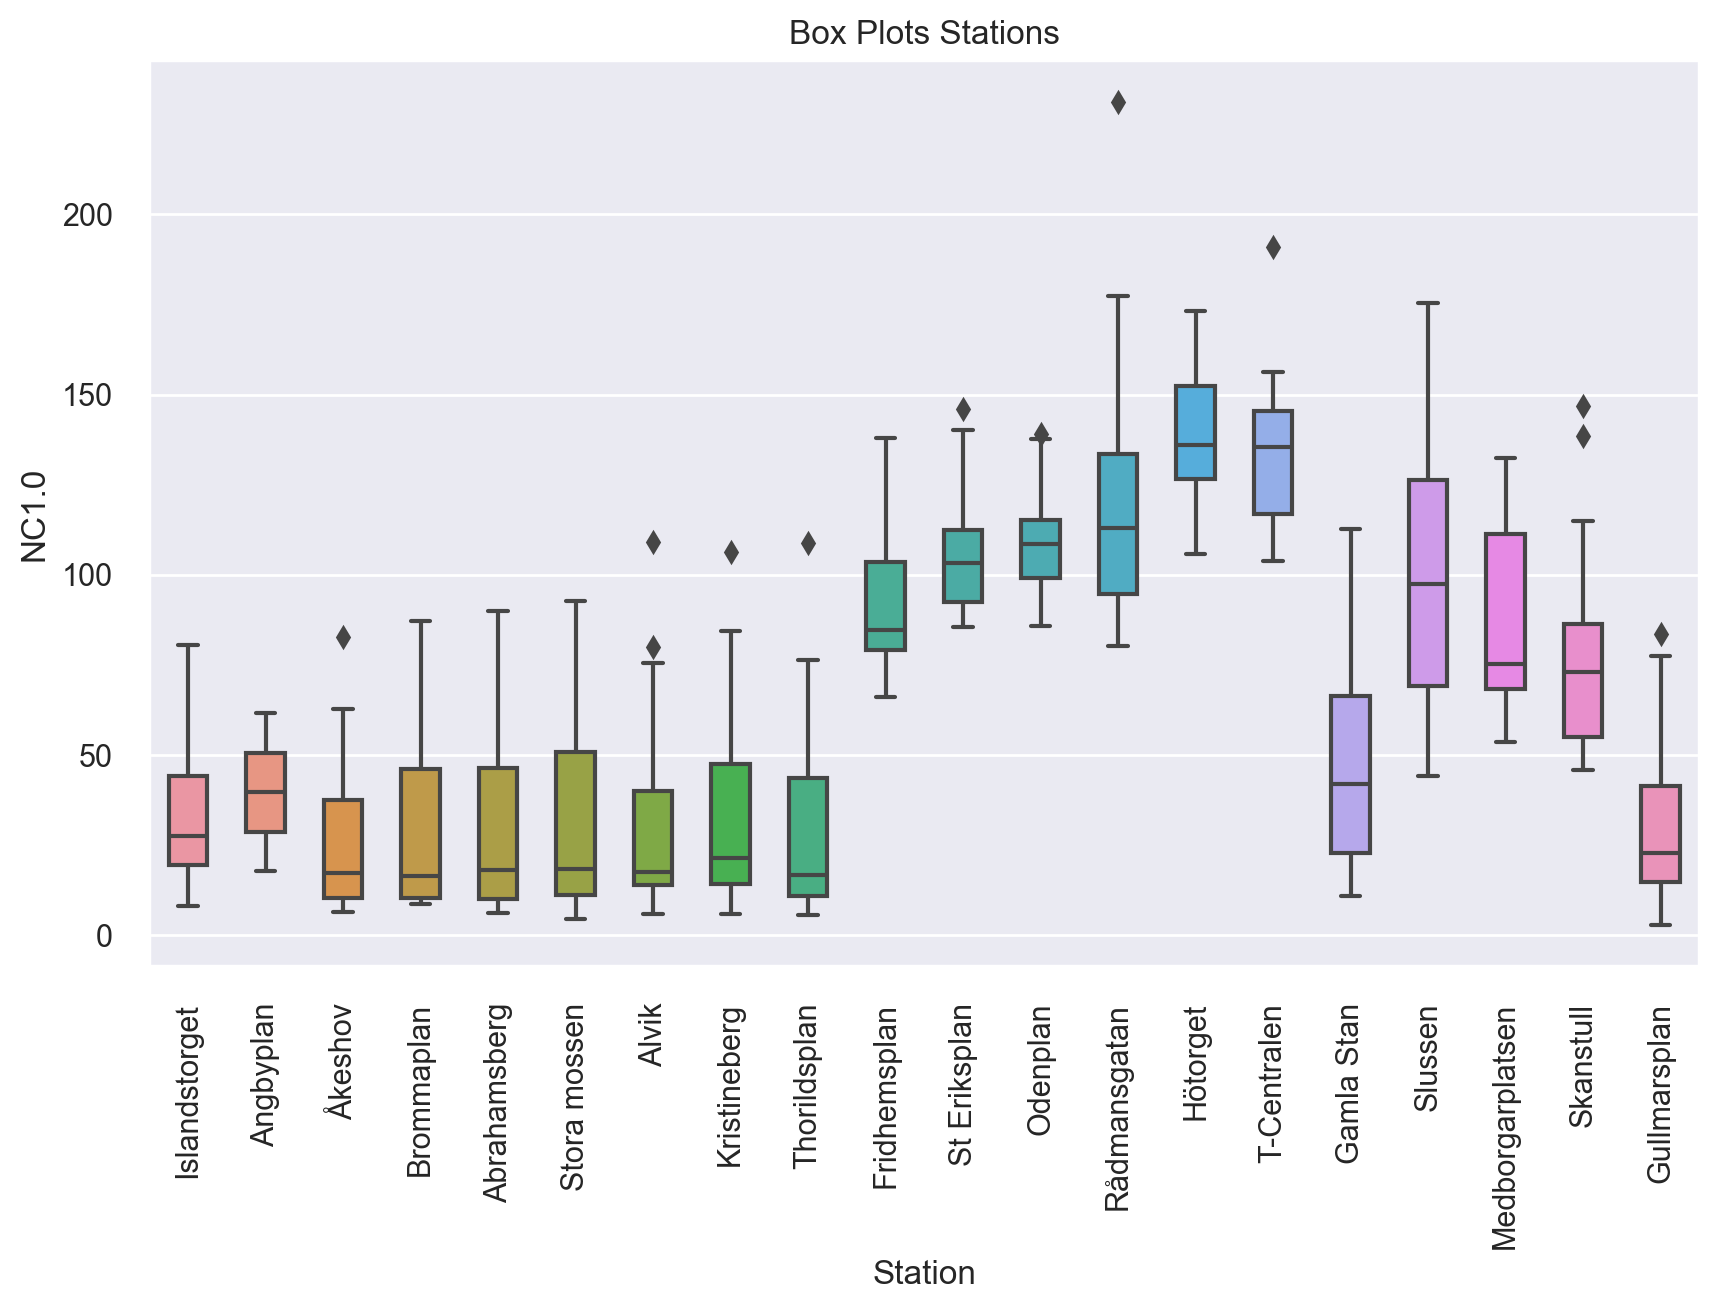

In [232]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y=param, data=s_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots({param}).pdf')

plt.show()

### Box plot with lines

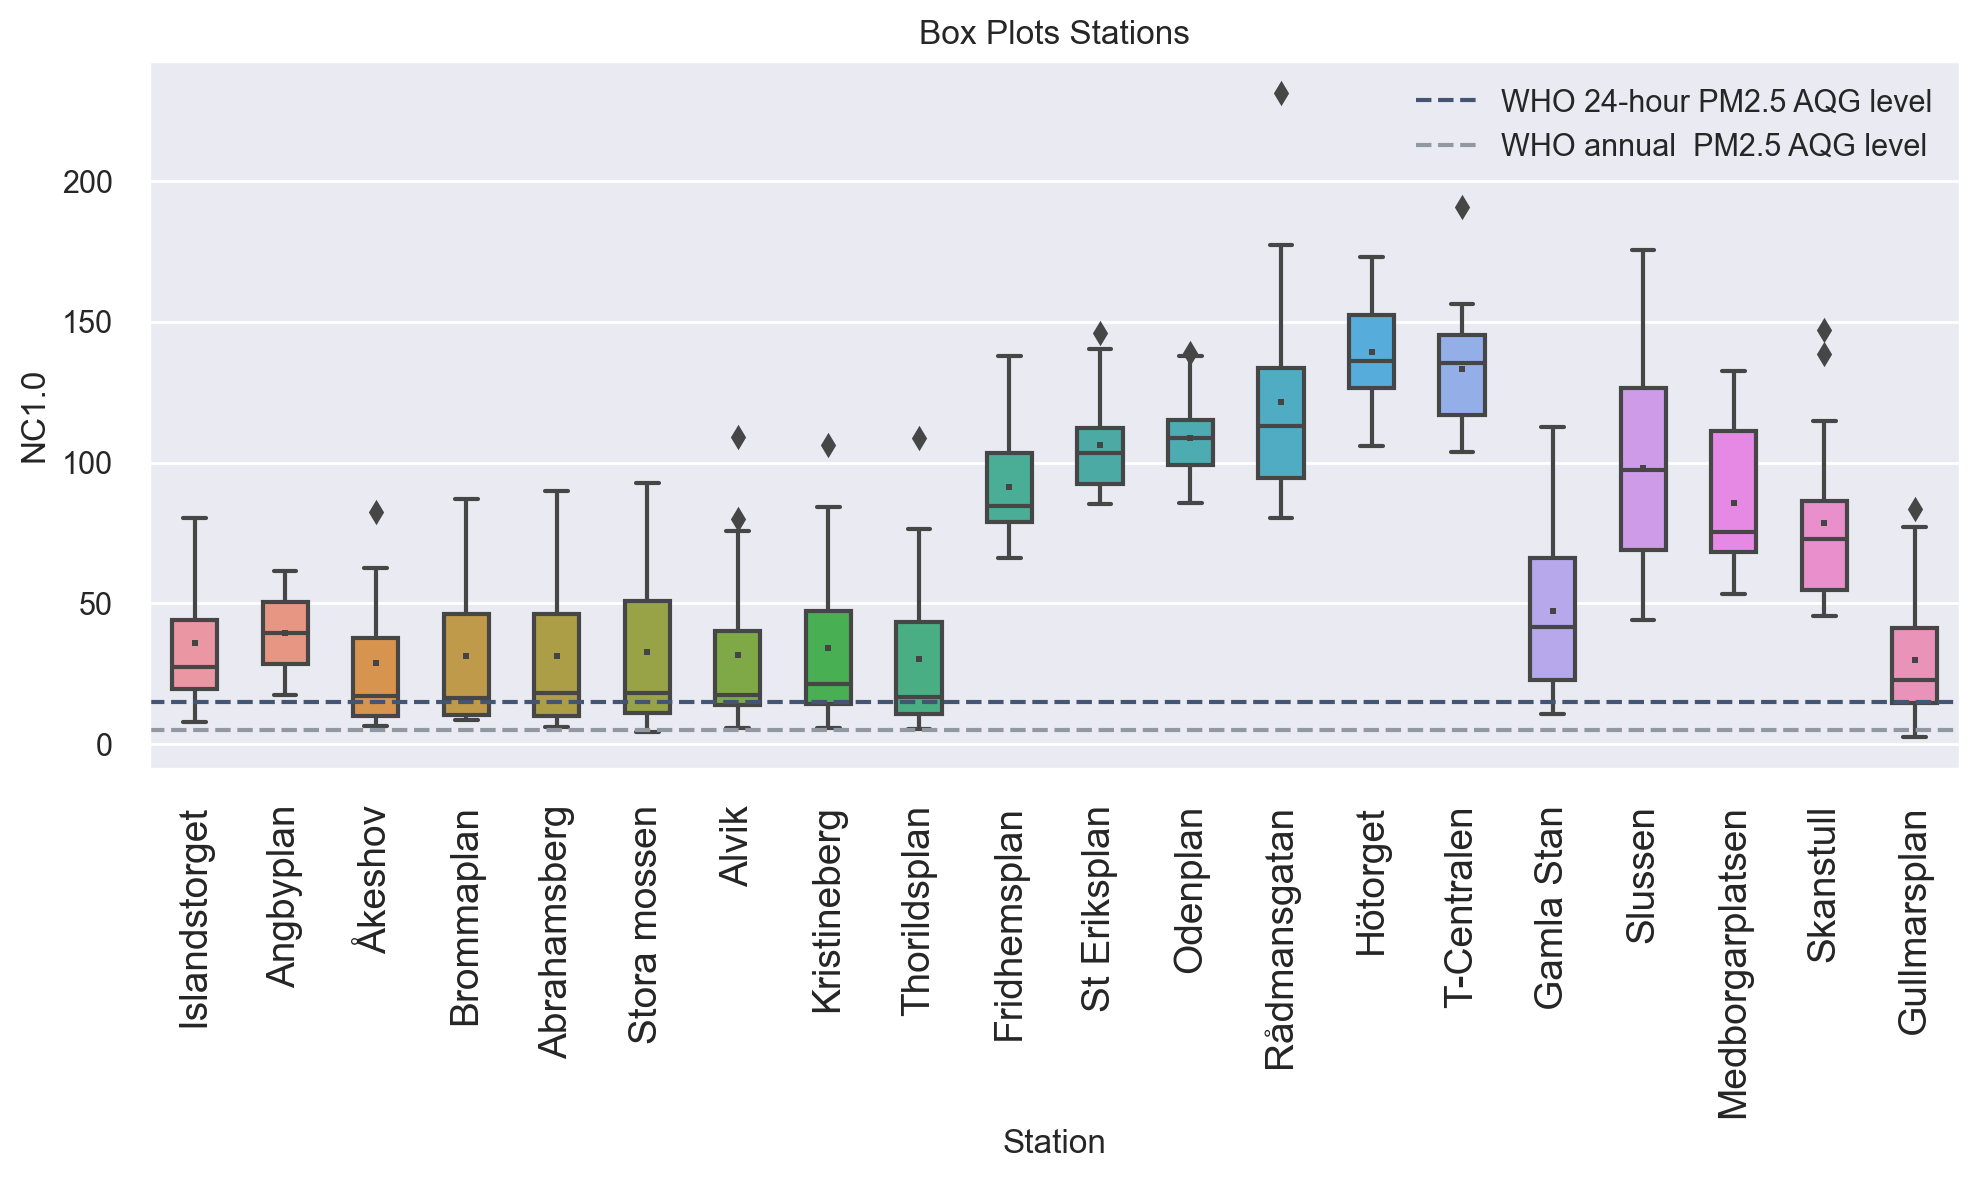

In [233]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(
    x='Station', 
    y=param, 
    data=s_df, 
    width=0.5, 
    order=get_green_line(), 
    showmeans=True,
    #meanline=True, 
    meanprops={"marker": 's',
                "markerfacecolor":"#444", 
                "markersize":"2"
    }
)

plt.axhline(15, label='WHO 24-hour PM2.5 AQG level', c='#435573', linestyle='--')
plt.axhline(5, label='WHO annual  PM2.5 AQG level', c='#9298a1', linestyle='--')


plt.legend()
plt.xticks(rotation=90, fontsize=14)
plt.title('Box Plots Stations')
plt.tight_layout()
plt.savefig(f'{fig_folder}/box_plots_lines_meandot({param}).pdf')

plt.show()

**Comments**

Hötorget, T-Centralen, and Rådmansgatan have the highest means.

### Quantiles and outliers

In [234]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
station_quantiles = s_df.groupby('Station').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

station_quantiles.to_csv(f'{fig_folder}/tables/station_quantiles({param}).csv')
station_quantiles[param].sort_values(by='outliers', ascending=False)

Q1          Q2          Q3        IQR  lowerLimit  \
Station                                                                       
Skanstull          54.827549   72.898713   86.249933  31.422384    7.693973   
Alvik              13.896720   17.510239   40.074832  26.178112  -25.370448   
Åkeshov            10.161823   17.102654   37.549429  27.387606  -30.919585   
Rådmansgatan       94.638113  113.005830  133.579828  38.941715   36.225540   
Thorildsplan       10.818380   16.717938   43.511695  32.693315  -38.221592   
T-Centralen       116.954058  135.384914  145.293038  28.338980   74.445587   
St Eriksplan       92.427848  103.233201  112.385655  19.957807   62.491137   
Gullmarsplan       14.739136   22.859657   41.240415  26.501278  -25.012781   
Kristineberg       14.263700   21.326336   47.363709  33.100009  -35.386315   
Odenplan           99.177093  108.635931  115.097033  15.919940   75.297182   
Stora mossen       11.151706   18.259035   50.824541  39.672836  -48.357548   
Slussen            69.006066   97.351217  126.392928  57.386863  -17.074228   
Abrahamsberg        9.961514   18.087507   46.258206  36.296692  -44.483525   
Islandstorget      19.430646   27.571628   44.014926  24.584281  -17.445775   
Hötorget          126.465413  136.075025  152.317833  25.852419   87.686784   
Gamla Stan         22.656482   41.764100   66.202121  43.545639  -42.661977   
Fridhemsplan       78.980327   84.598310  103.479858  24.499531   42.231030   
Brommaplan         10.245479   16.374824   46.194522  35.949043  -43.678085   
Angbyplan          28.616521   39.616816   50.617112  22.000591   -4.384366   
Medborgarplatsen   68.251689   75.192130  111.272549  43.020860    3.720398   

                  upperLimit  outliers  prcnt_outliers  count  
Station                                                        
Skanstull         133.383509       2.0       11.764706     17  
Alvik              79.342000       2.0       10.000000     20  
Åkeshov            78.630837       1.0       11.111111      9  
Rådmansgatan      191.992400       1.0        5.882353     17  
Thorildsplan       92.551667       1.0        5.882353     17  
T-Centralen       187.801508       1.0        5.882353     17  
St Eriksplan      142.322366       1.0        5.000000     20  
Gullmarsplan       80.992332       1.0        6.250000     16  
Kristineberg       97.013723       1.0        5.000000     20  
Odenplan          138.976944       1.0        3.703704     27  
Stora mossen      110.333795       0.0        0.000000     11  
Slussen           212.473222       0.0        0.000000     18  
Abrahamsberg      100.703244       0.0        0.000000     11  
Islandstorget      80.891348       0.0        0.000000      4  
Hötorget          191.096461       0.0        0.000000     16  
Gamla Stan        131.520580       0.0        0.000000     17  
Fridhemsplan      140.229155       0.0        0.000000     20  
Brommaplan        100.118086       0.0        0.000000     11  
Angbyplan          83.617998       0.0        0.000000      2  
Medborgarplatsen  175.803839       0.0        0.000000     17

**Comment**

Some stations have outliers. What happened during these sessions?

In [235]:
outlier_ids = print_outliers(s_df, station_quantiles, param)

=== OUTLIERS ===
Alvik:
	20211011-2 - NC1.0 = 79.84
	20211004-2 - NC1.0 = 109.17

Gullmarsplan:
	20211011-1 - NC1.0 = 83.44

Kristineberg:
	20211004-2 - NC1.0 = 106.39

Odenplan:
	20211004-1 - NC1.0 = 139.02

Rådmansgatan:
	20210929-1 - NC1.0 = 231.31

Skanstull:
	20210930-3 - NC1.0 = 138.49
	20211004-1 - NC1.0 = 146.94

St Eriksplan:
	20211004-2 - NC1.0 = 146.03

T-Centralen:
	20211004-1 - NC1.0 = 190.92

Thorildsplan:
	20211004-2 - NC1.0 = 108.77

Åkeshov:
	20211004-2 - NC1.0 = 82.56

Unique outliers: ['20210929-1', '20210930-3', '20211004-1', '20211004-2', '20211011-1', '20211011-2']


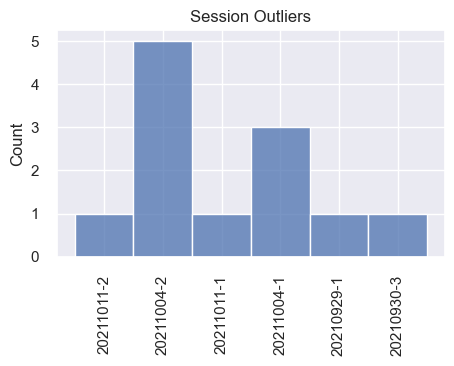

In [236]:
fig, ax = plt.subplots(figsize=[5, 3], dpi=100)

sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

**Comment**

These sessions are worth examining and comparing with other sources. Especially session 20211004-2, as it contains 5 outliers within the same session!

**Looking at outliers 2021-10-04-2**

In [237]:
tmp1 = s_df[s_df['Session Id'] == '20211004-2'][['Station', param]]

tmp2 = s_df.groupby('Station').agg({param: 'mean'})[param][list(tmp1.Station.unique())]
tmp2 = tmp2.to_frame()

tmp2['Station'] = tmp2.index
tmp2 = tmp2.reset_index(drop=True)

tmp2 = tmp2.rename(columns={param: f'{param} Mean'})

tmp = pd.merge(tmp1, tmp2, on='Station')

tmp['Diff'] = tmp[param] - tmp[f'{param} Mean']

print(get_middle_value(s_df[s_df['Session Id'] == '20211004-2'], 'Timestamp'))

tmp

2021-10-04 16:53:57


Station       NC1.0  NC1.0 Mean       Diff
0       Åkeshov   82.559141   28.802221  53.756920
1    Brommaplan   87.001889   31.163681  55.838209
2  Abrahamsberg   89.868501   31.319354  58.549147
3  Stora mossen   92.789011   32.894281  59.894730
4         Alvik  109.168848   31.701708  77.467139
5  Kristineberg  106.393613   34.147035  72.246578
6  Thorildsplan  108.765296   30.274870  78.490425
7  Fridhemsplan  137.960229   91.287272  46.672957
8  St Eriksplan  146.033853  106.237564  39.796290

In [238]:
# Åkeshov
station = 'Åkeshov'

station_mean = s_df[s_df['Station'] == station][param].mean()

s_tmp = s_df[s_df['Station'] == station].groupby('Session Id').agg({param: 'mean'})
s_tmp['Diff'] = s_tmp[param] - station_mean

s_tmp

NC1.0       Diff
Session Id                      
20210927-2   6.368066 -22.434155
20210928-2  16.998661 -11.803560
20210929-2  37.549429   8.747208
20210930-1  62.600429  33.798208
20211004-2  82.559141  53.756920
20211005-3  18.280784 -10.521437
20211006-3  10.161823 -18.640398
20211007-3  17.102654 -11.699567
20211012-4   7.599002 -21.203219

In [239]:
s_df[s_df['Session Id'] == '20211006-3']

Unnamed: 0  Session Id            Timestamp   Period       Station  \
185         185  20211006-3  2021-10-06 19:00:20  Offtime       Åkeshov   
179         179  20211006-3  2021-10-06 18:53:30  Offtime    Brommaplan   
177         177  20211006-3  2021-10-06 18:48:12  Offtime  Abrahamsberg   
183         183  20211006-3  2021-10-06 18:43:17  Offtime  Stora mossen   
178         178  20211006-3  2021-10-06 18:37:06  Offtime         Alvik   
181         181  20211006-3  2021-10-06 18:32:05  Offtime  Kristineberg   
184         184  20211006-3  2021-10-06 18:27:53  Offtime  Thorildsplan   
180         180  20211006-3  2021-10-06 18:23:25  Offtime  Fridhemsplan   
182         182  20211006-3  2021-10-06 18:19:12  Offtime  St Eriksplan   

    Sensors      NC0.5       NC1.0       NC2.5        NC10  \
185   ABCDE   8.713770   10.161823   10.237009   10.251894   
179   ABCDE   8.564553   10.004422   10.089877   10.106718   
177   ABCDE   6.837000    7.992071    8.062571    8.076643   
183   ABCDE   7.825392    9.237517    9.376476    9.404394   
178   ABCDE  11.474286   13.898254   14.327361   14.413948   
181   ABCDE   8.534039   10.460463   10.858381   10.939093   
184   ABCDE   7.499722    9.556694   10.137807   10.255745   
180   ABCDE  64.134710   86.891365   95.145358   96.824352   
182   ABCDE  71.554464  102.791012  115.721012  118.338274   

     TypicalParticleSize      PM1.0      PM2.5      PM4.0       PM10  \
185             0.567363   1.283080   1.402442   1.439283   1.446566   
179             0.581287   1.264615   1.392843   1.437473   1.446533   
177             0.583690   1.010619   1.115119   1.152524   1.159857   
183             0.629488   1.175742   1.351135   1.438200   1.455589   
178             0.701766   1.798274   2.270000   2.568472   2.627857   
181             0.732651   1.363452   1.788968   2.070000   2.126121   
184             0.821571   1.274664   1.871113   2.294321   2.379214   
180             0.931058  11.982918  20.225068  26.337969  27.560546   
182             1.010149  14.597351  27.390268  37.065536  39.000625   

     Temperature   Humidity        Date      Time Station Order  
185    23.726460  47.658142  2021-10-06  19:00:20       Åkeshov  
179    23.785362  47.423883  2021-10-06  18:53:30    Brommaplan  
177    23.895714  46.934048  2021-10-06  18:48:12  Abrahamsberg  
183    24.037884  46.660495  2021-10-06  18:43:17  Stora mossen  
178    23.861111  47.038294  2021-10-06  18:37:06         Alvik  
181    23.692349  47.032918  2021-10-06  18:32:05  Kristineberg  
184    23.647463  48.197709  2021-10-06  18:27:53  Thorildsplan  
180    23.208362  58.659386  2021-10-06  18:23:25  Fridhemsplan  
182    22.175298  60.785714  2021-10-06  18:19:12  St Eriksplan

In [240]:
tmp1 = s_df[s_df['Session Id'] == '20211004-1'][['Station', 'PM2.5']]

tmp2 = s_df.groupby('Station').agg({'PM2.5': 'mean'})['PM2.5'][list(tmp1.Station.unique())]
tmp2 = tmp2.to_frame()

tmp2['Station'] = tmp2.index
tmp2 = tmp2.reset_index(drop=True)

tmp2 = tmp2.rename(columns={'PM2.5': 'PM2.5 Mean'})

tmp = pd.merge(tmp1, tmp2, on='Station')

tmp['Diff'] = tmp['PM2.5'] - tmp['PM2.5 Mean']

print(get_middle_value(s_df[s_df['Session Id'] == '20211004-1'], 'Timestamp'))

tmp

2021-10-04 08:31:57


Station      PM2.5  PM2.5 Mean      Diff
0          Odenplan  22.778814   27.472746 -4.693933
1      Rådmansgatan  21.447759   29.590381 -8.142622
2          Hötorget  31.159536   35.551594 -4.392058
3       T-Centralen  30.233566   31.267734 -1.034168
4        Gamla Stan  15.031646    8.218249  6.813397
5           Slussen  28.617097   22.001547  6.615550
6  Medborgarplatsen  18.785012   17.858760  0.926252
7         Skanstull  21.742810   14.880032  6.862778

## Rush and off hours

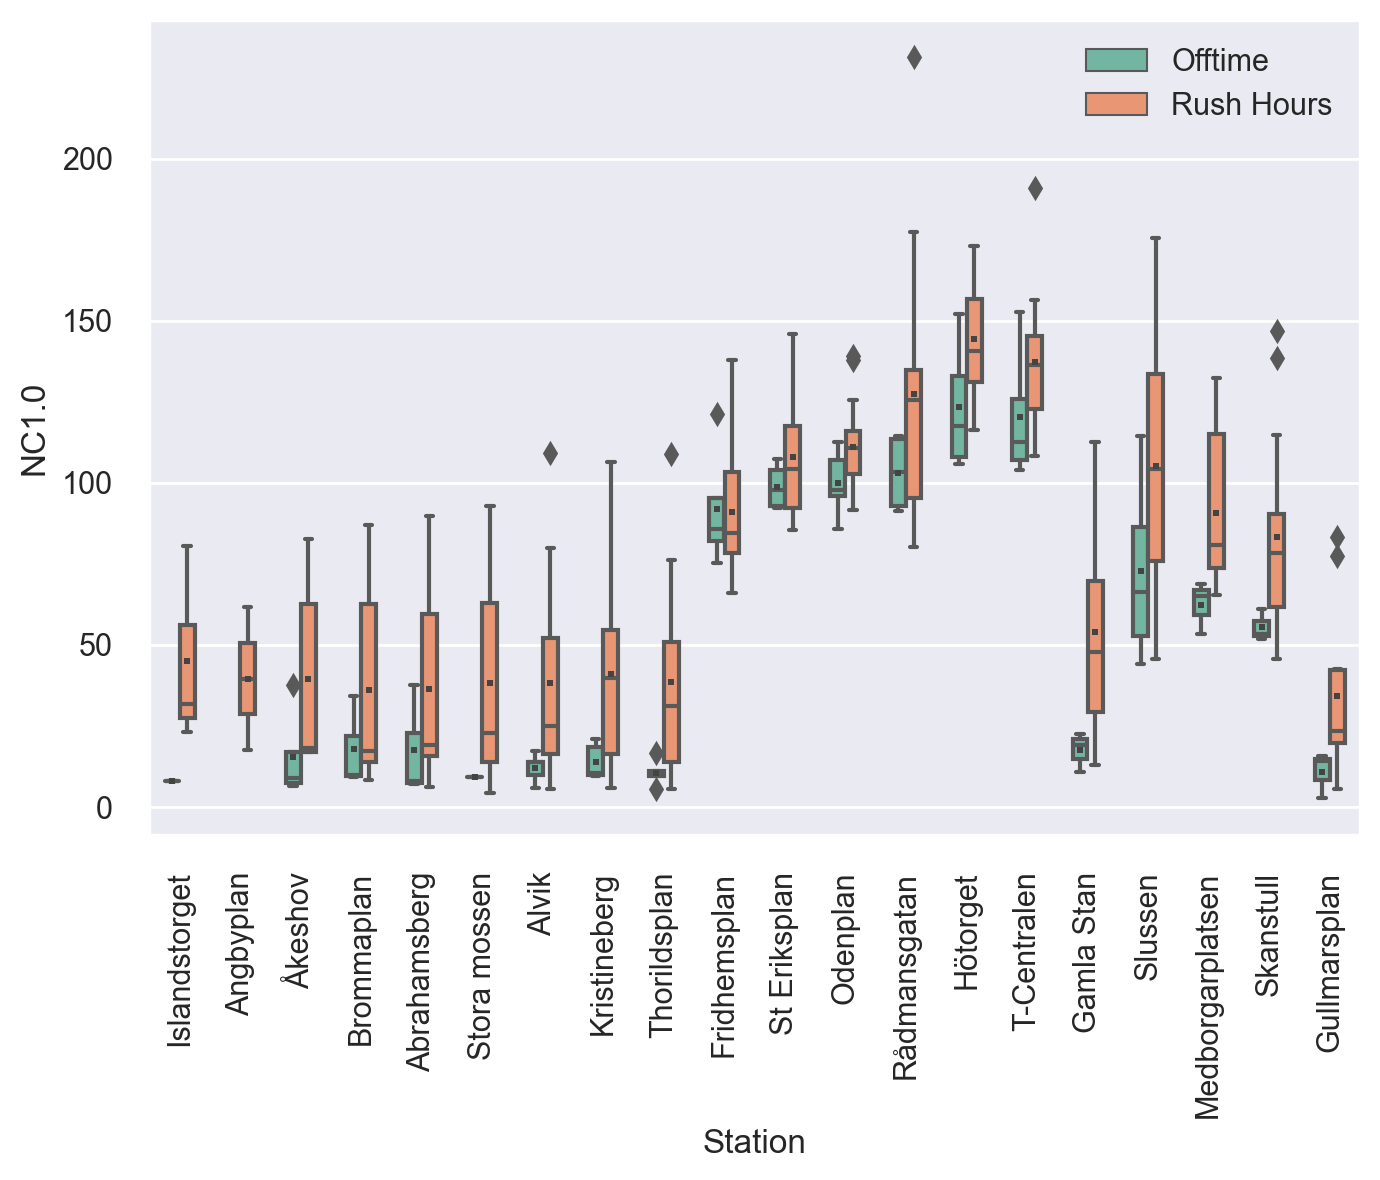

In [241]:
fig, ax = plt.subplots(figsize=[7,6], dpi=200)

plot_df = s_df.copy()
plot_df['Period'] = plot_df['Period'].apply(lambda x: 'Rush Hours' if x in ['Evening rush', 'Morning rush'] else x)

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2",
    showmeans=True,
    #meanline=True, 
    meanprops={"marker": 's',
                "markerfacecolor":"#444", 
                "markersize":"2"
    }
)

plt.legend()
plt.xticks(rotation=90)
#plt.title('Box Plots Stations')
plt.tight_layout()
plt.savefig(f'{fig_folder}/box_plots_rush_vs_offtime({param}).pdf')

plt.show()

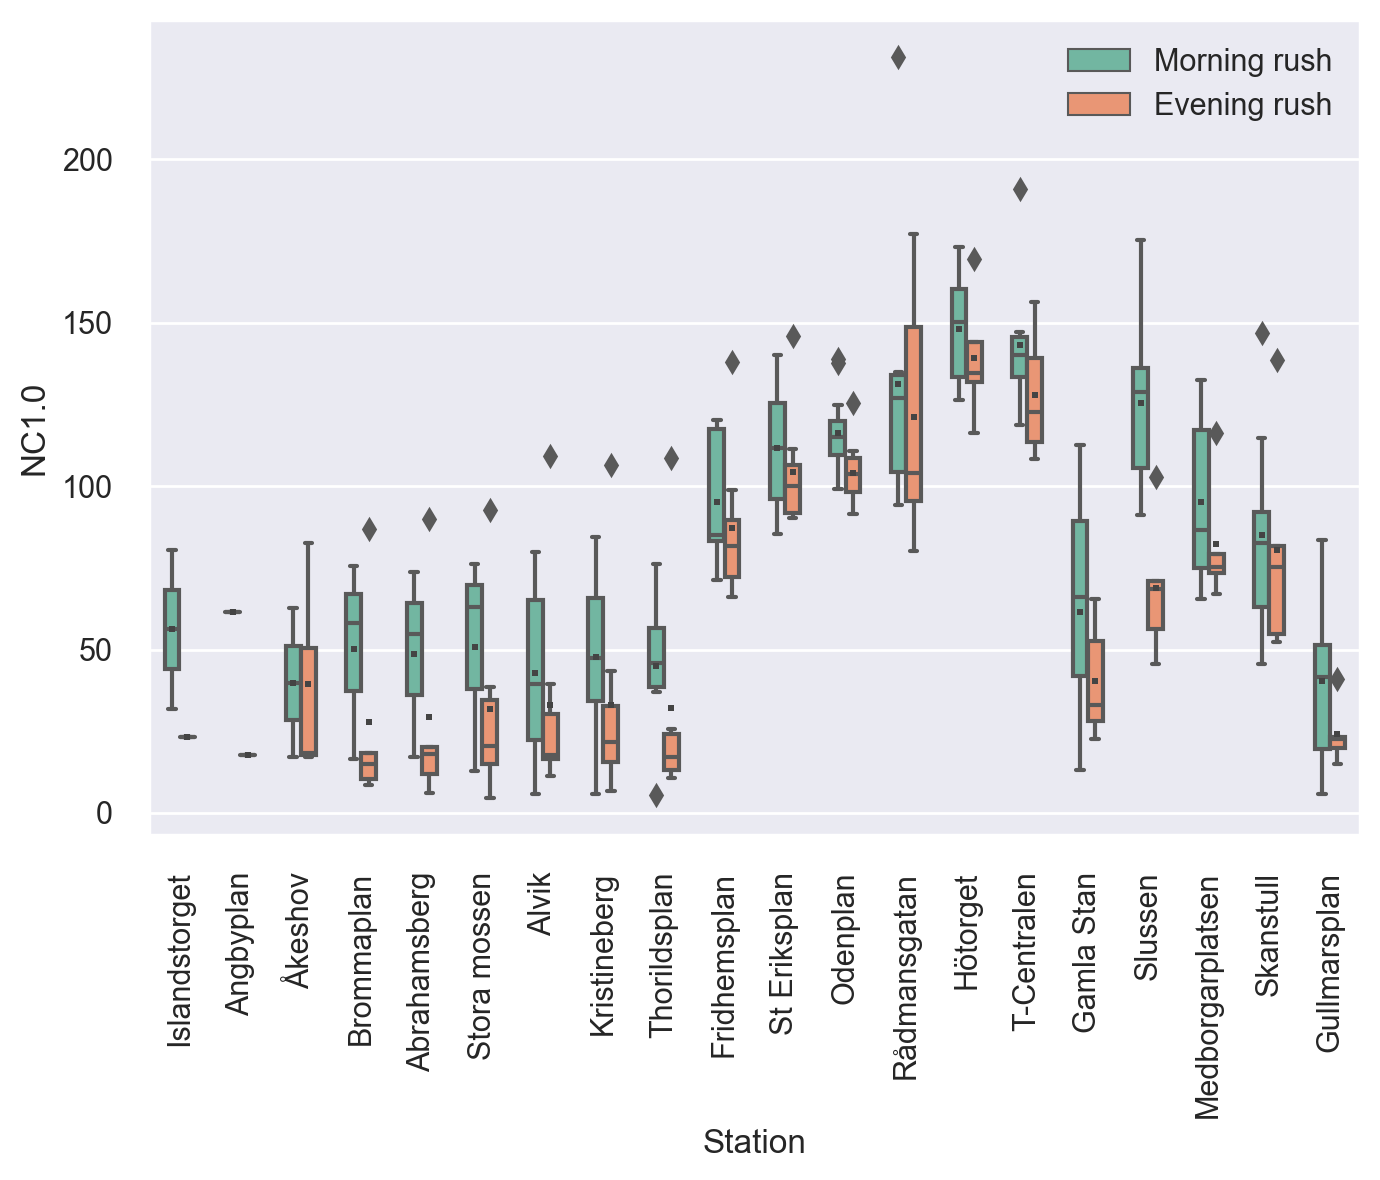

In [242]:
fig, ax = plt.subplots(figsize=[7,6], dpi=200)

plot_df = s_df.loc[s_df['Period'] != 'Offtime']

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2",
    showmeans=True,
    #meanline=True, 
    meanprops={"marker": 's',
                "markerfacecolor":"#444", 
                "markersize":"2"
    }
)

plt.legend()
plt.xticks(rotation=90)
#plt.title('Box Plots Stations')
plt.tight_layout()
plt.savefig(f'{fig_folder}/box_plots_morning_evening_rush({param}).pdf')

plt.show()

### Above-ground vs below-ground

\textit{Fridhemsplan}, \textit{St Eriksplan}, \textit{Odenplan}, \textit{Rådmansgatan}, \textit{Hötorget}, \textit{T-Centralen}, \textit{Slussen}, \textit{Medborgarplatsen}, and \textit{Skanstull}

In [219]:
underground_stations = ['Fridhemsplan', 'St Eriksplan', 'Odenplan', 'Rådmansgatan', 'Hötorget', 'T-Centralen', 'Slussen', 'Medborgarplatsen', 'Skanstull']

under_df = s_df[s_df['Station'].isin(underground_stations)]
above_df = s_df[~s_df['Station'].isin(underground_stations)]

print('Under')
print(f'{round(under_df["PM2.5"].mean(), 2)}±{round(sample_std(under_df["PM2.5"]), 2)}')

print('Above')
print(f'{round(above_df["PM2.5"].mean(), 2)}±{round(sample_std(above_df["PM2.5"]), 2)}')


Under
24.63±8.27
Above
4.96±3.78


### Histograms

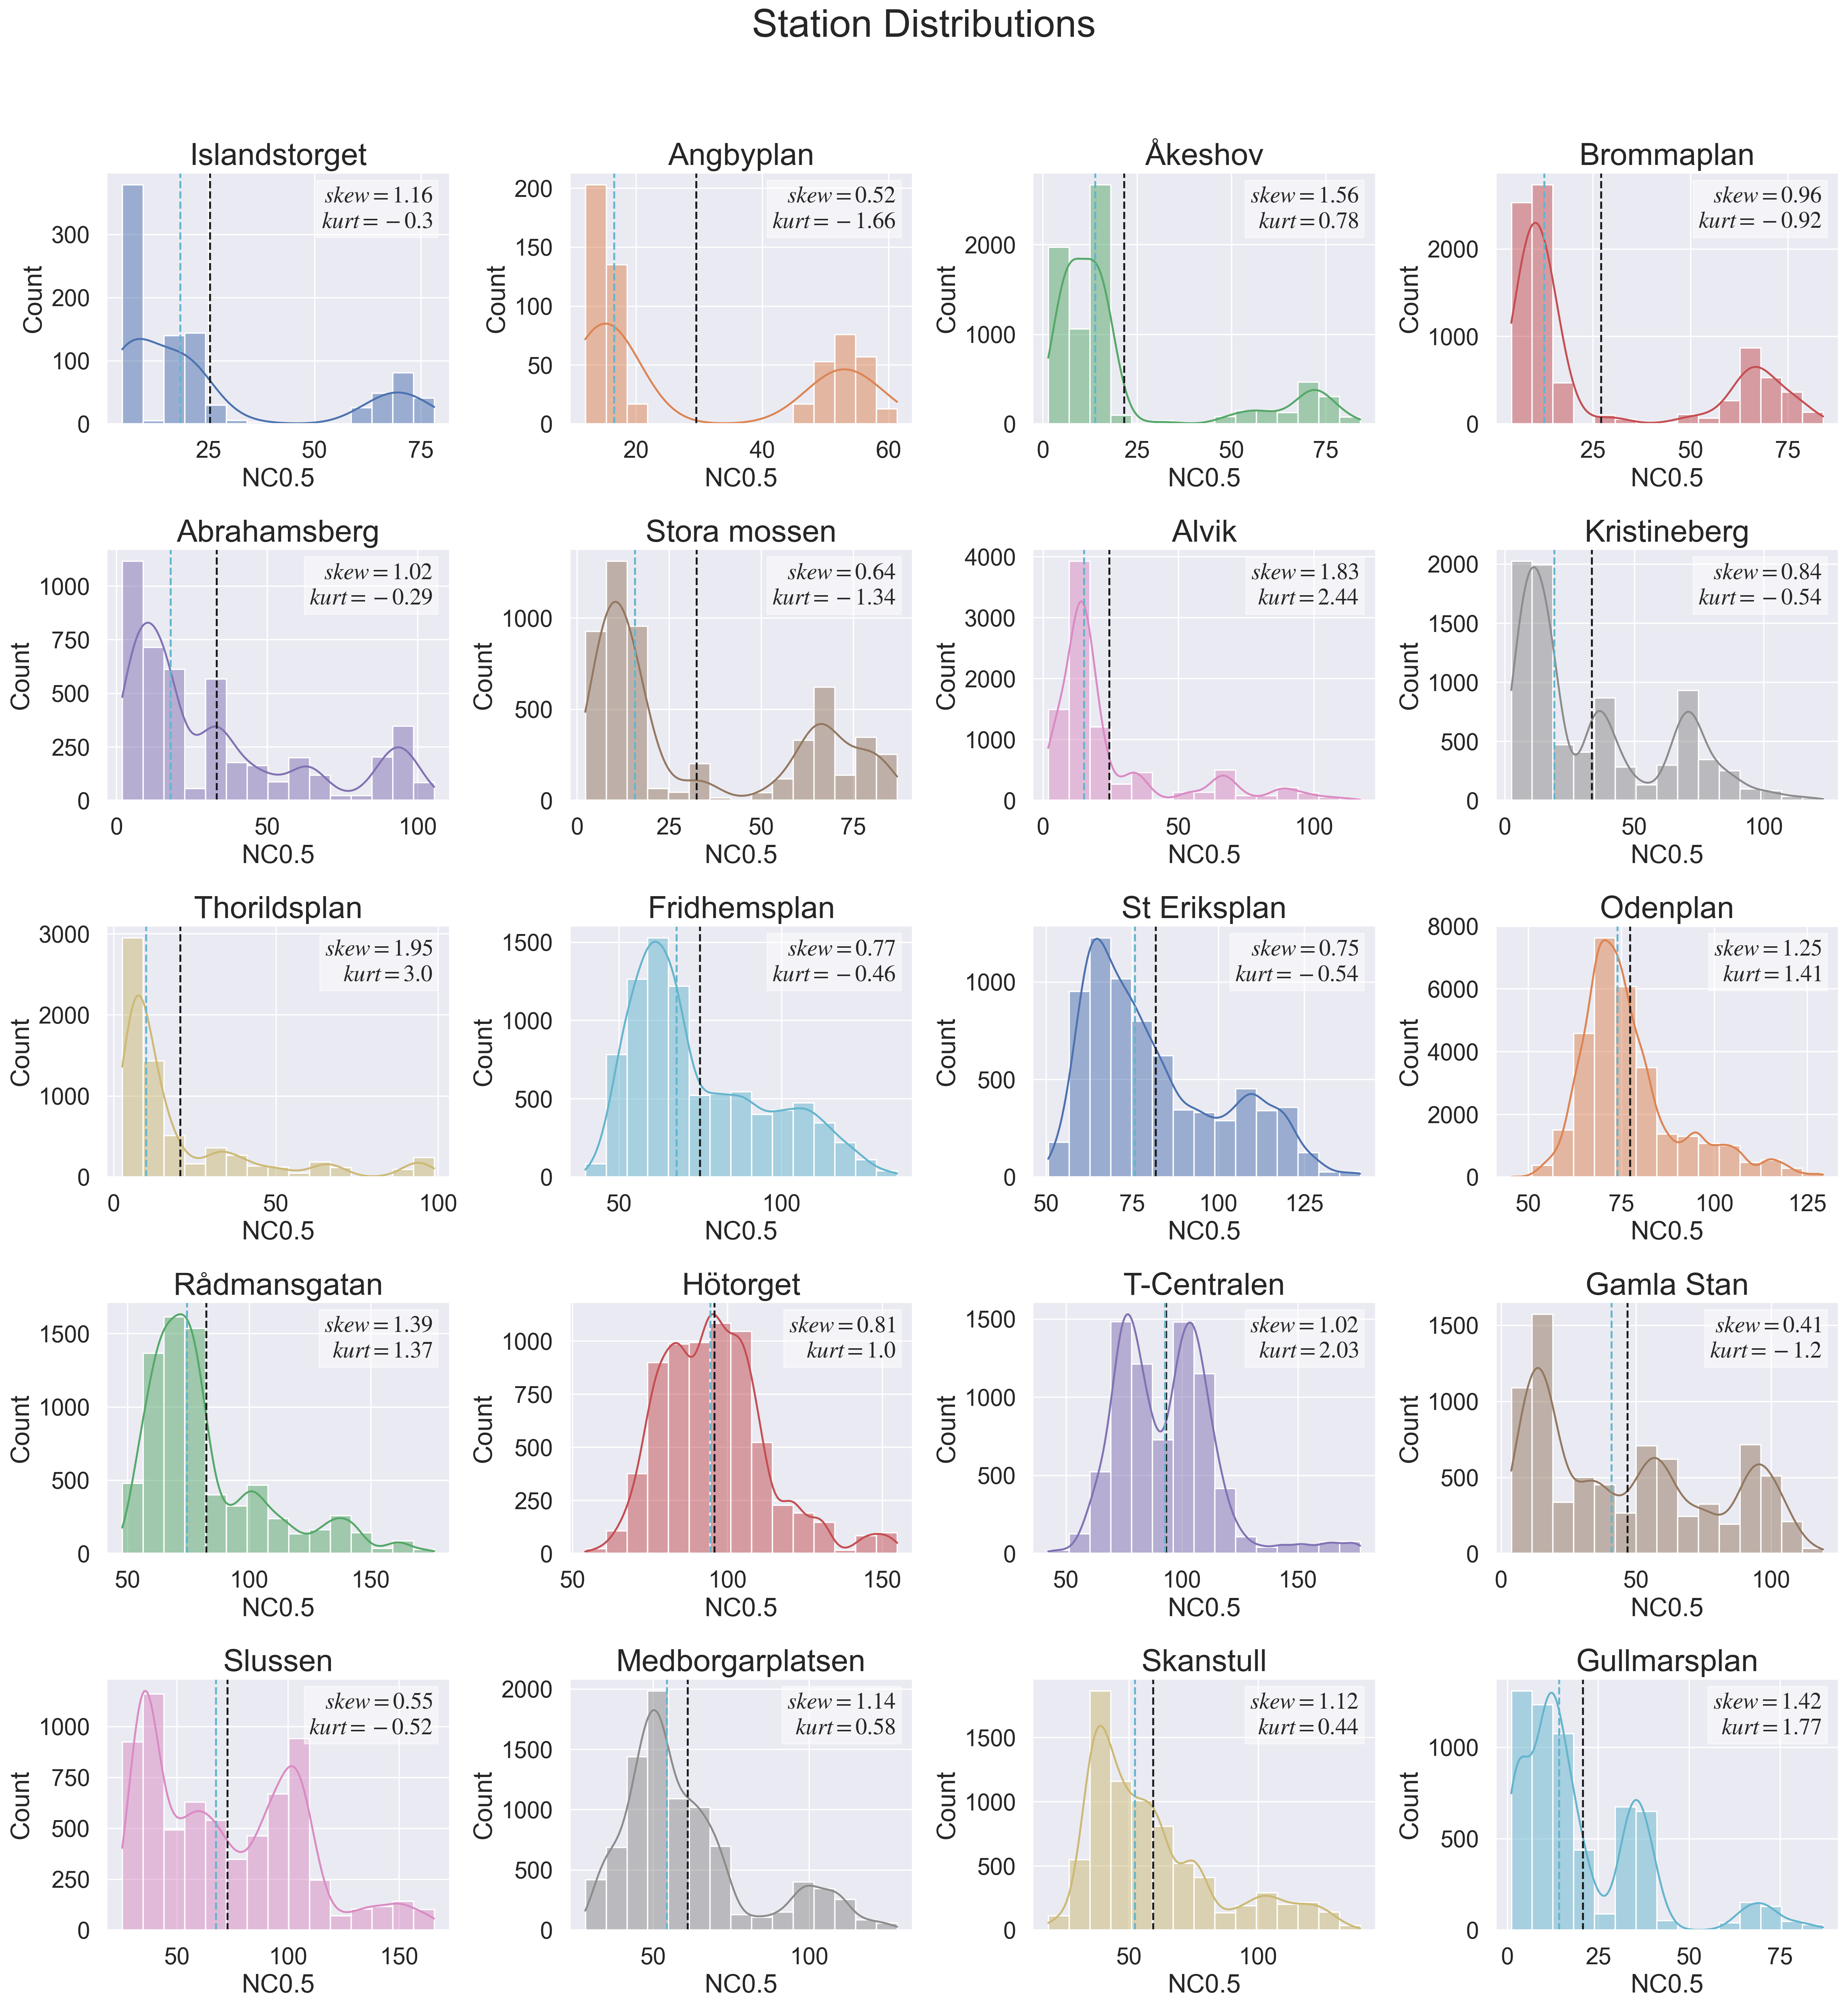

In [220]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/distributions({param}).pdf',
    param=param,
    with_textbox=True,
    column_count=4,
    bins=15
)

### Normal distribution

In [221]:
normal = r_df.groupby('Station').agg({param: [skew, kurtosis]})
normal[param].to_csv(f'{fig_folder}/tables/normal({param}).csv')

normal

NC0.5          
                      skew  kurtosis
Station                             
Abrahamsberg      1.020922 -0.290153
Alvik             1.834360  2.436836
Angbyplan         0.522649 -1.662090
Brommaplan        0.959634 -0.915981
Fridhemsplan      0.767976 -0.458320
Gamla Stan        0.410267 -1.202373
Gullmarsplan      1.419149  1.771554
Hötorget          0.805478  0.997215
Islandstorget     1.161024 -0.302372
Kristineberg      0.837872 -0.537512
Medborgarplatsen  1.135092  0.582159
Odenplan          1.250892  1.412355
Rådmansgatan      1.394451  1.366938
Skanstull         1.117053  0.436687
Slussen           0.550341 -0.516756
St Eriksplan      0.747036 -0.537708
Stora mossen      0.642367 -1.337982
T-Centralen       1.024478  2.034708
Thorildsplan      1.950412  3.002949
Åkeshov           1.558535  0.780707

#### QQ Plots

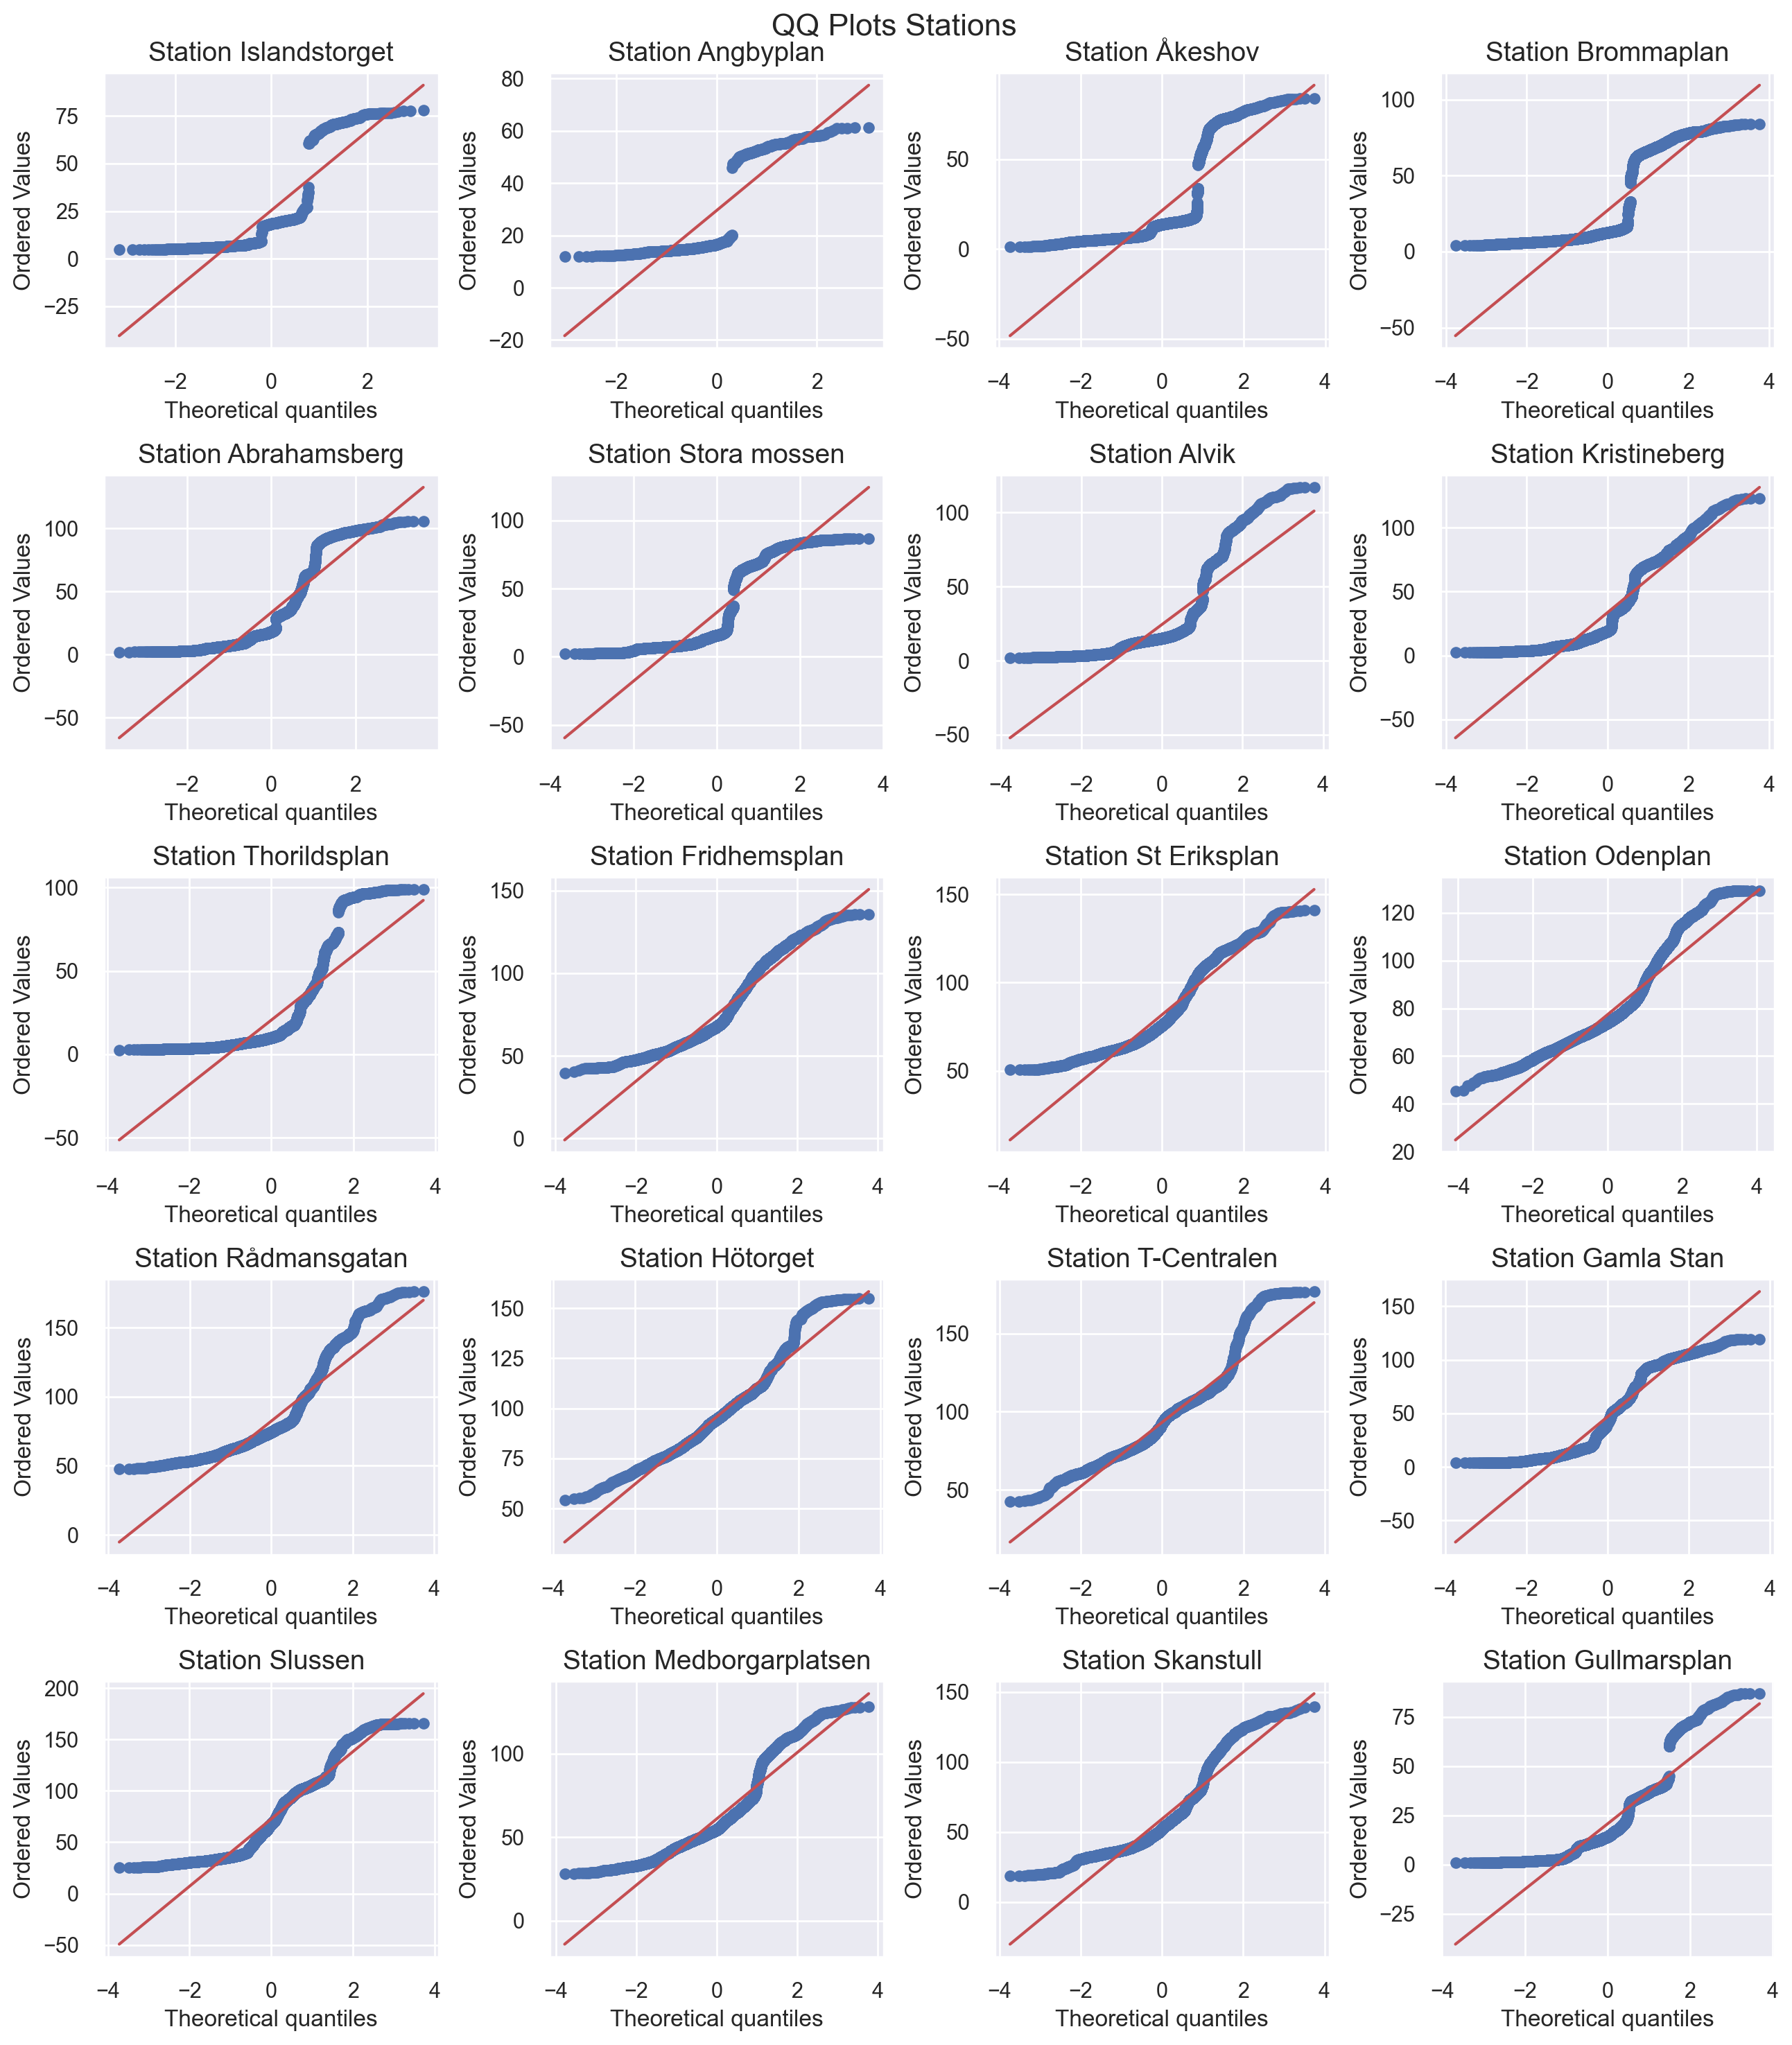

In [222]:
plot_QQ_plots(
    r_df, 
    title='QQ Plots Stations', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots({param}).pdf',
    col_count=4,
    row_count=5,
    label='Station',
    size=(13, 15)
)

### Sensor diffs

How much do the sensor means per session per station differ? Compute standard deviation per session per station.

In [101]:
station_diffs = {}
station_diffs_CI = {}

for session_id, grp in r_df.groupby('Session Id'):
    for station, station_grp in grp.groupby('Station'):
        if station not in station_diffs:
            station_diffs[station] = []
            station_diffs_CI[station] = []
            
        # Compute std
        station_diffs[station].append(sample_std(station_grp[param].values))
        
        # Compute CI
        station_diffs_CI[station].append(CI95(station_grp[param].values))
            
# Convert into one long array and make a histogram
mean_station_diffs = {s: np.mean(v) for s, v in station_diffs.items()}
mean_station_diffs_CI = {s: np.mean(v) for s, v in station_diffs_CI.items()}

station_diffs_df = pd.DataFrame(list(mean_station_diffs.items()), columns=['station', 'mean sensor std'])

station_diffs_df['CI95'] = [v[1] for v in mean_station_diffs_CI.items()]
station_diffs_df['order'] = [get_green_line().index(station) for station in mean_station_diffs.keys()]

print(f'Total mean sensor diff: {station_diffs_df["mean sensor std"].mean()}')

station_diffs_df.to_csv(f'{fig_folder}/tables/sensors_diffs_per_station({param}).csv')

station_diffs_df.sort_values(by=['mean sensor std'], ascending=False)

Total mean sensor diff: 1.466236069988657


station  mean sensor std      CI95  order
2           Hötorget         3.934129  0.405267     13
8        T-Centralen         3.361600  0.338440     14
15      St Eriksplan         2.754218  0.332050     10
5       Rådmansgatan         2.747722  0.290752     12
4           Odenplan         2.567057  0.222192     11
7            Slussen         2.566548  0.277594     16
12      Fridhemsplan         2.037218  0.218167      9
3   Medborgarplatsen         1.844523  0.179658     17
6          Skanstull         1.647639  0.155257     18
0         Gamla Stan         1.035677  0.108361     15
9       Abrahamsberg         0.645219  0.057234      4
13     Islandstorget         0.568537  0.169955      0
14      Kristineberg         0.558587  0.053685      7
1       Gullmarsplan         0.545975  0.071892     19
17      Thorildsplan         0.503136  0.057563      8
10             Alvik         0.465381  0.050892      6
18           Åkeshov         0.413297  0.039031      2
16      Stora mossen         0.386574  0.043805      5
19         Angbyplan         0.385657  0.047560      1
11        Brommaplan         0.356028  0.035141      3

### How much do every single sensor differ per station?

In [102]:
diffs = {}

for station, grp in r_df.groupby('Station'):
    diffs[station] = {}
    for sensor, sensor_grp in grp.groupby('Sensor'):
        diffs[station][sensor] = sample_std(sensor_grp[param].values)

diffs_df = pd.concat([pd.DataFrame(diffs[s].values(), index=diffs[s].keys(), columns=[s]).T for s in r_df['Station'].unique()])

diffs_df.loc['Avg'] = diffs_df.mean()

diffs_df.to_csv(f'{fig_folder}/tables/sensor_diff_per_station({param}).csv')

diffs_df

1          2         3         4         5         6  \
Islandstorget     3.211636   3.327906  3.792090  3.326726  3.991383  0.352996   
Angbyplan         0.103136   2.943800  0.266006  0.217073  0.121511       NaN   
Åkeshov           3.473360   3.892637  3.330701  3.808935  3.719053       NaN   
Brommaplan        4.162947   3.919091  4.233889  4.354806  4.359644  0.886205   
Abrahamsberg      4.974648   4.003359  5.129500  5.264613  4.962984  3.179298   
Stora mossen      4.322610   4.176057  4.442939  4.158027  4.572867  1.129900   
Alvik             3.615531   3.384691  3.914462  4.322196  3.965400  4.789921   
Kristineberg      4.222561   4.100721  4.430787  4.285757  4.542133  4.221945   
Thorildsplan      3.596889   3.526476  4.170309  4.279091  3.951474  5.437646   
Fridhemsplan      6.592349   6.477304  6.637651  6.405331  6.186111  2.079107   
St Eriksplan      3.739309   4.109427  3.592675  3.899974  3.240527  3.271821   
Odenplan          3.861561   5.145351  3.658167  3.979487  3.385664  3.665386   
Rådmansgatan      3.577910   8.668129  3.576100  5.284563  2.719432  2.071747   
Hötorget          5.814305   5.733901  5.653610  5.301326  3.739305  4.396209   
T-Centralen       3.674931   5.526434  5.942806  4.953943  3.302212  4.255966   
Gamla Stan        5.111991   4.814662  5.689908  4.432985  5.018309  5.413300   
Slussen           8.874653  10.164860  9.170583  9.347808  8.563737  9.035944   
Medborgarplatsen  3.112649   3.316503  2.835944  2.186402  3.002374  2.141532   
Skanstull         5.170299   6.104303  3.956903  6.349599  3.972025  4.562252   
Gullmarsplan      1.495907   2.490693  1.562963  1.723835  1.459728  1.191967   
Avg               4.135459   4.791315  4.299400  4.394124  3.938794  3.449063   

                         B         A         C         D         E  
Islandstorget     0.193980       NaN       NaN       NaN       NaN  
Angbyplan         0.222070       NaN       NaN       NaN       NaN  
Åkeshov           3.095617  0.763321  0.502801  0.618481  0.433365  
Brommaplan        1.935534  0.396169  0.368404  0.393666  0.452739  
Abrahamsberg      2.132978  0.552404  0.524485  0.636494  0.570312  
Stora mossen      2.364820  0.732751  0.434401  0.630076  0.619683  
Alvik             2.059057  1.113315  1.395966  1.590813  1.459765  
Kristineberg      2.289297  1.629217  2.152977  1.876298  1.977068  
Thorildsplan      2.078409  1.292157  1.680511  1.597459  1.461563  
Fridhemsplan      3.624775  3.982647  4.531233  2.342707  3.652811  
St Eriksplan      2.422835  2.005176  3.392008  2.127479  2.721049  
Odenplan          3.886975  3.289066  3.317498  2.622258  3.381406  
Rådmansgatan      7.840622  5.602798  7.543046  6.397265  8.138053  
Hötorget          5.839084  8.174895  7.062115  4.919497  6.831521  
T-Centralen       6.891009  5.807254  5.770219  5.162003  6.366759  
Gamla Stan        3.589185  3.183958  4.237687  3.497978  3.687728  
Slussen           7.832109  6.623500  7.987723  6.976425  8.147521  
Medborgarplatsen  2.530274  4.053206  2.715570  2.226126  1.977148  
Skanstull         4.281109  3.365592  2.236536  2.201035  2.585218  
Gullmarsplan      3.032066  3.507322  3.119415  2.817734  3.007711  
Avg               3.407090  3.115264  3.276255  2.701877  3.192857

## Anova results between stations

This makes sense. We want to see if the stations differ!!

In [103]:
anova_df = perform_ANOVA(
    r_df,
    param=param,
    alpha=0.01,
    group_name='Station'
)

anova_df.to_csv(f'{fig_folder}/tables/StationsAnova({param}).csv')
anova_df

0
SST                            23826791.251044
SSW                             3844694.775636
SSB                            19982096.475408
Alpha                                     0.01
F-stat                            42317.099894
F-crit                                1.904901
P-value                                    0.0
F-stat > F-crit  True (Significant Difference)
p-value < alpha  True (Significant Difference)

In [104]:
tukey_df = r_df[[param, 'Station']]

tukey = pairwise_tukeyhsd(
    endog=tukey_df[param],
    groups=tukey_df['Station'],
    alpha=0.01
)

tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
tukey_df.to_csv(f'{fig_folder}/tables/StationsTukey({param}).csv')

print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.01            
     group1           group2      meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------
    Abrahamsberg            Alvik  -1.1709  0.001  -1.5362  -0.8056   True
    Abrahamsberg        Angbyplan  -0.7033 0.1493  -1.5875   0.1809  False
    Abrahamsberg       Brommaplan  -0.9579  0.001  -1.3269   -0.589   True
    Abrahamsberg     Fridhemsplan  14.2364  0.001  13.8693  14.6035   True
    Abrahamsberg       Gamla Stan    3.853  0.001   3.4801   4.2259   True
    Abrahamsberg     Gullmarsplan  -1.3167  0.001  -1.7103  -0.9231   True
    Abrahamsberg         Hötorget  30.3868  0.001  30.0043  30.7693   True
    Abrahamsberg    Islandstorget  -1.3186  0.001   -2.044  -0.5932   True
    Abrahamsberg     Kristineberg   0.3501 0.0215  -0.0188   0.7191  False
    Abrahamsberg Medborgarplatsen  12.2422  0.001  11.8778  12.6066   True
    Abrahamsberg         

# Focus on Hötorget

In [105]:
focus_s_df = s_df.loc[s_df.Station == 'Hötorget'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Hötorget'].sort_values(by=['Sensor'])

### Box plots sensors

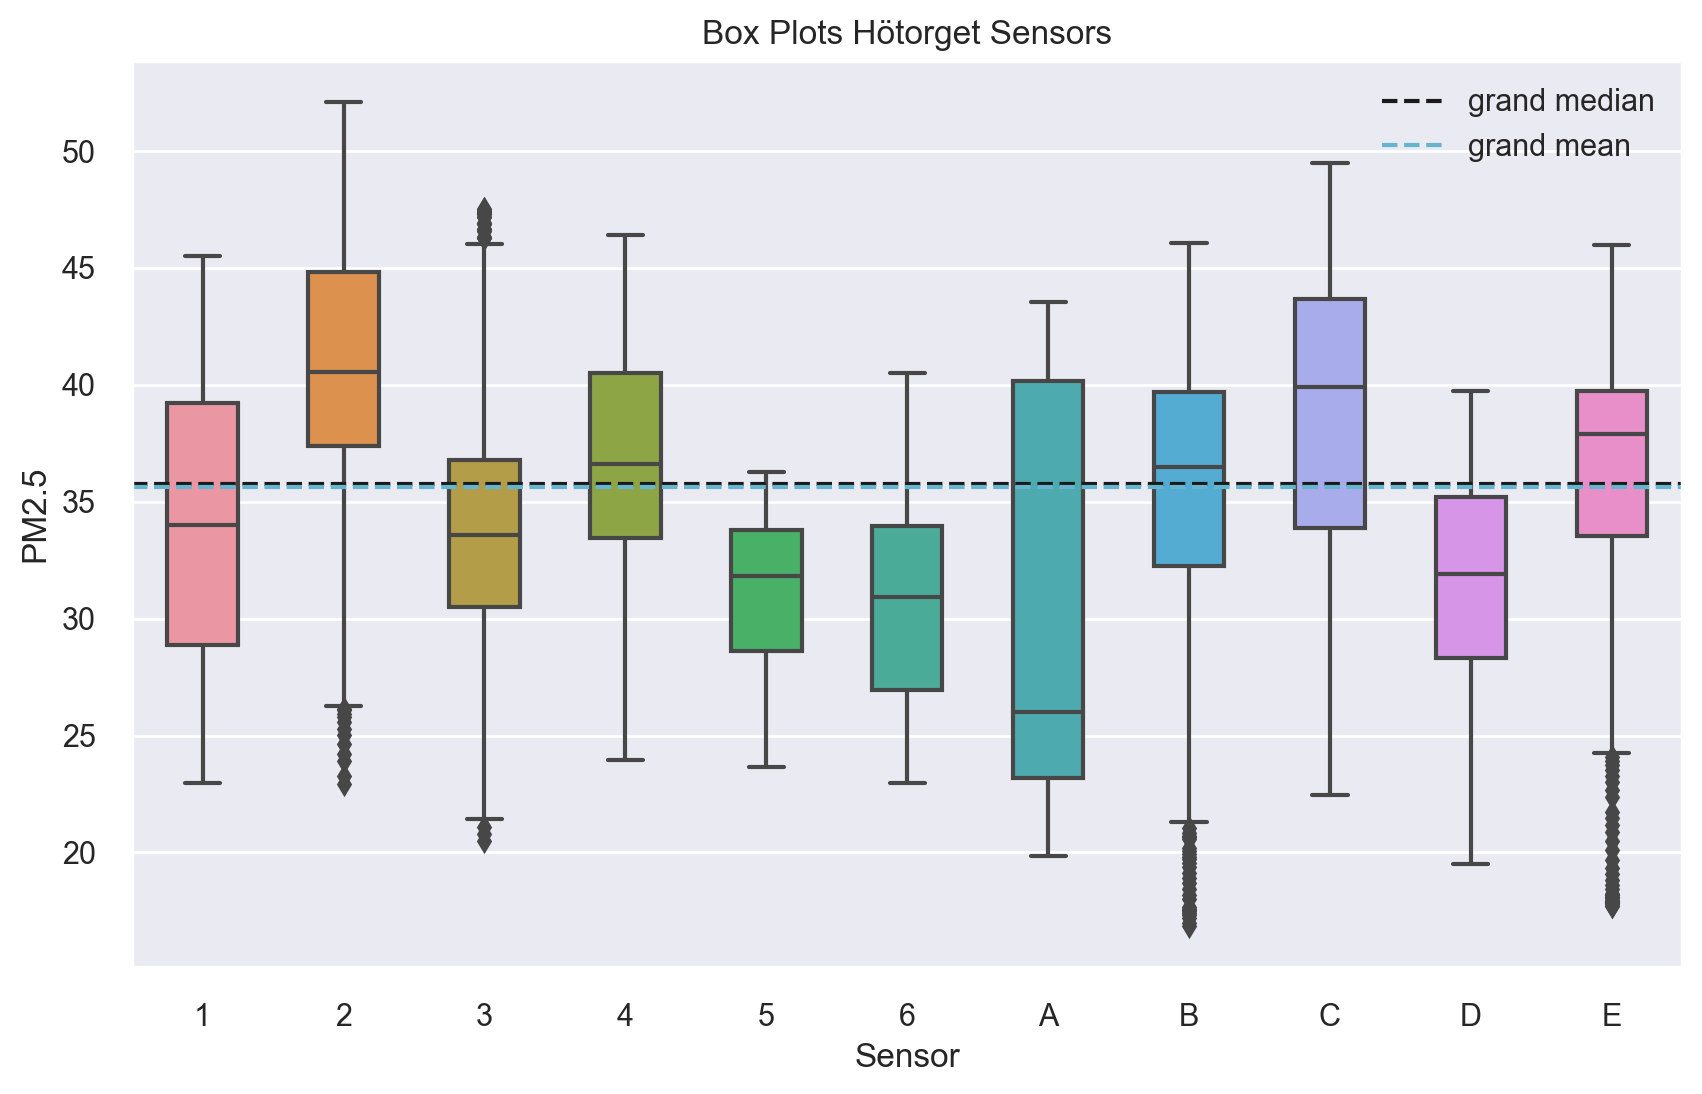

In [106]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=focus_r_df, width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.legend()
plt.title('Box Plots Hötorget Sensors')
plt.savefig(f'{fig_folder}/Hotorget_box_plot_sensor({param}).pdf')
plt.show()

In [107]:
station_diffs['Hötorget']

[4.0736740178738104,
 4.836107249572132,
 4.3176641444329755,
 4.200456895111019,
 4.095857392192398,
 3.6546224331469284,
 3.577856861524022,
 2.8958005360981685,
 4.630738192358802,
 3.2499391624067093,
 2.2882067383528177,
 5.190721846190268,
 4.796964758970221,
 4.125968110044006,
 3.4485611272785137,
 3.5629251266539566]

In [108]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles.to_csv(f'{fig_folder}/tables/Hotorget_quantiles({param}).csv')
quantiles

PM2.5                                                           \
             Q1      Q2       Q3      IQR lowerLimit upperLimit outliers   
Sensor                                                                     
1       28.8850  33.990  39.2350  10.3500   13.36000   54.76000      0.0   
2       37.3800  40.530  44.8150   7.4350   26.22750   55.96750     12.0   
3       30.5150  33.590  36.7850   6.2700   21.11000   46.19000     27.0   
4       33.4300  36.600  40.5100   7.0800   22.81000   51.13000      0.0   
5       28.6300  31.840  33.8100   5.1800   20.86000   41.58000      0.0   
6       26.9600  30.930  33.9750   7.0150   16.43750   44.49750      0.0   
A       23.2025  26.010  40.1850  16.9825   -2.27125   65.65875      0.0   
B       32.2700  36.480  39.7000   7.4300   21.12500   50.84500     27.0   
C       33.8975  39.925  43.6825   9.7850   19.22000   58.36000      0.0   
D       28.3350  31.920  35.2050   6.8700   18.03000   45.51000      0.0   
E       33.5375  37.900  39.7425   6.2050   24.23000   49.05000     40.0   

                             
       prcnt_outliers count  
Sensor                       
1            0.000000   506  
2            0.935308  1283  
3            3.233533   835  
4            0.000000   773  
5            0.000000   345  
6            0.000000   271  
A            0.000000   218  
B            2.072141  1303  
C            0.000000   424  
D            0.000000   423  
E            9.345794   428

### Box plot sessions

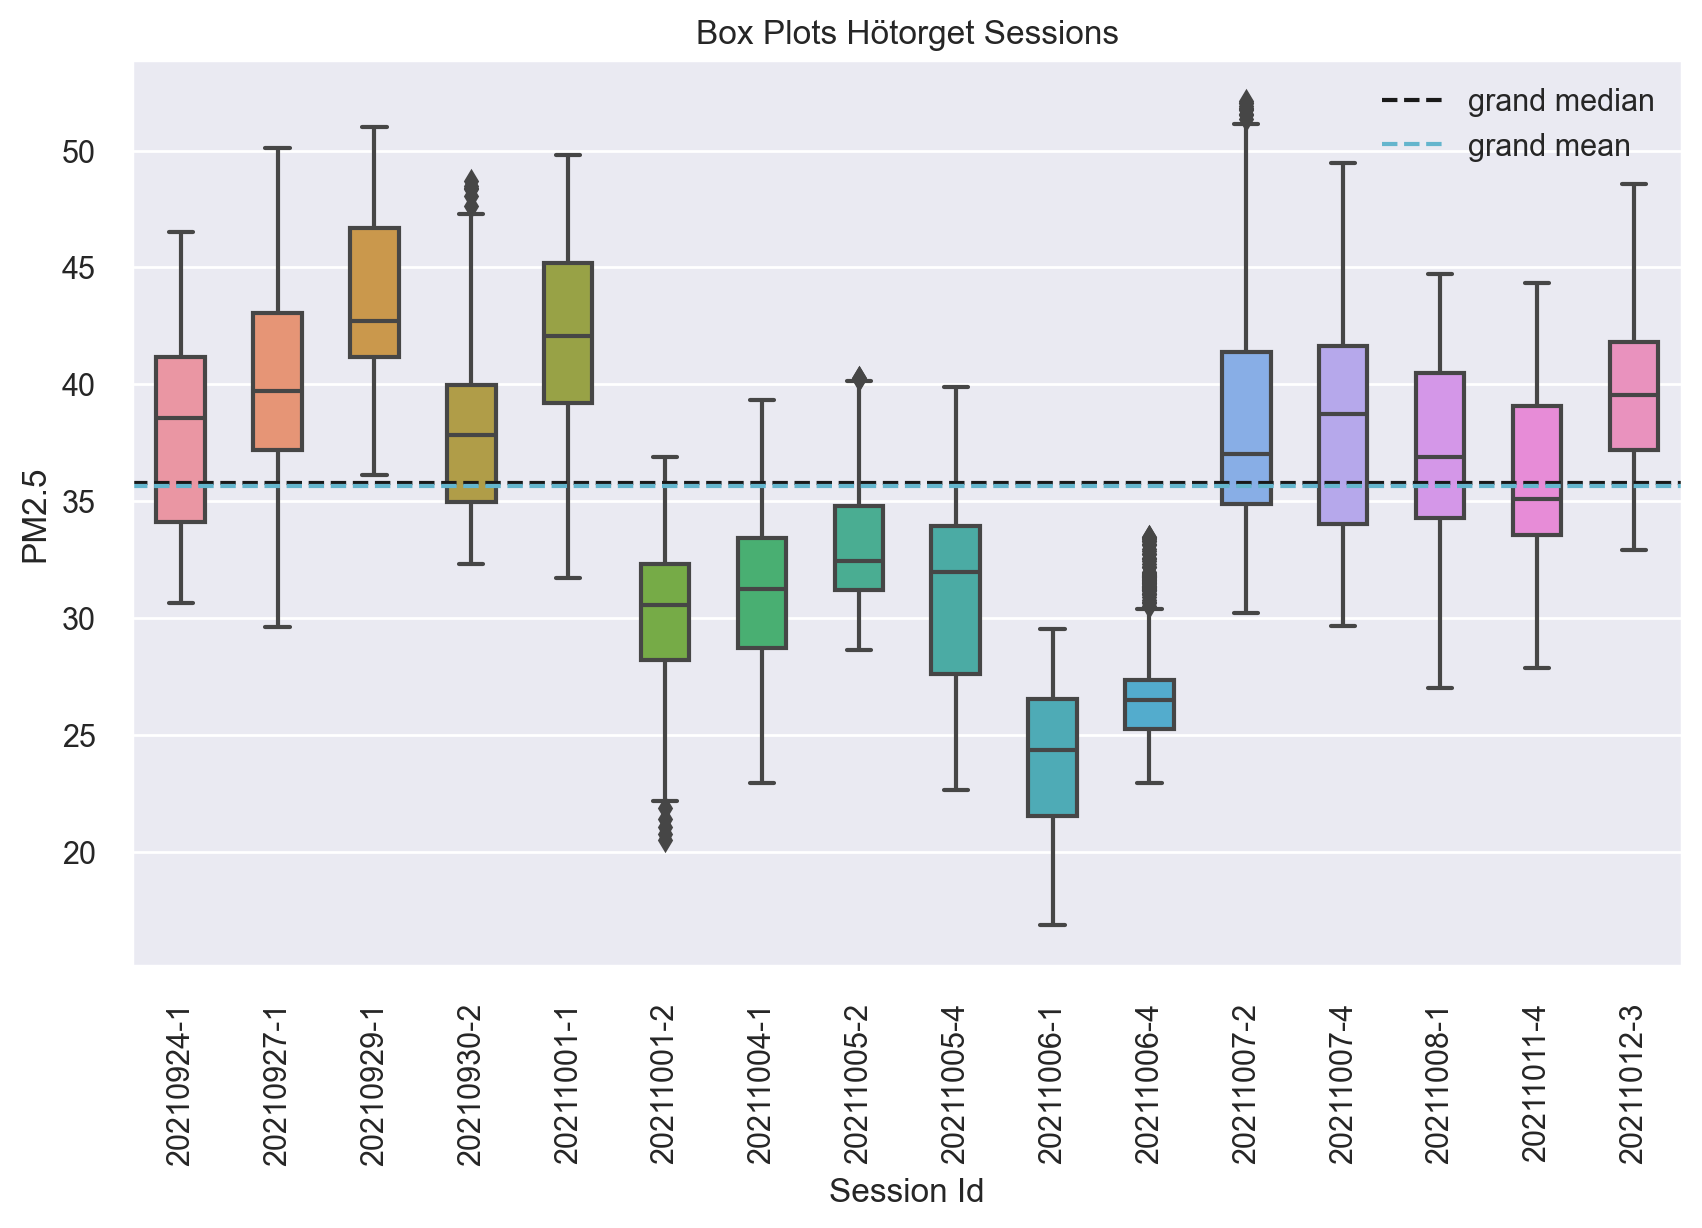

In [109]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Hötorget Sessions')
plt.savefig(f'{fig_folder}/Hotorget_box_plot_sessions({param}).pdf')
plt.show()

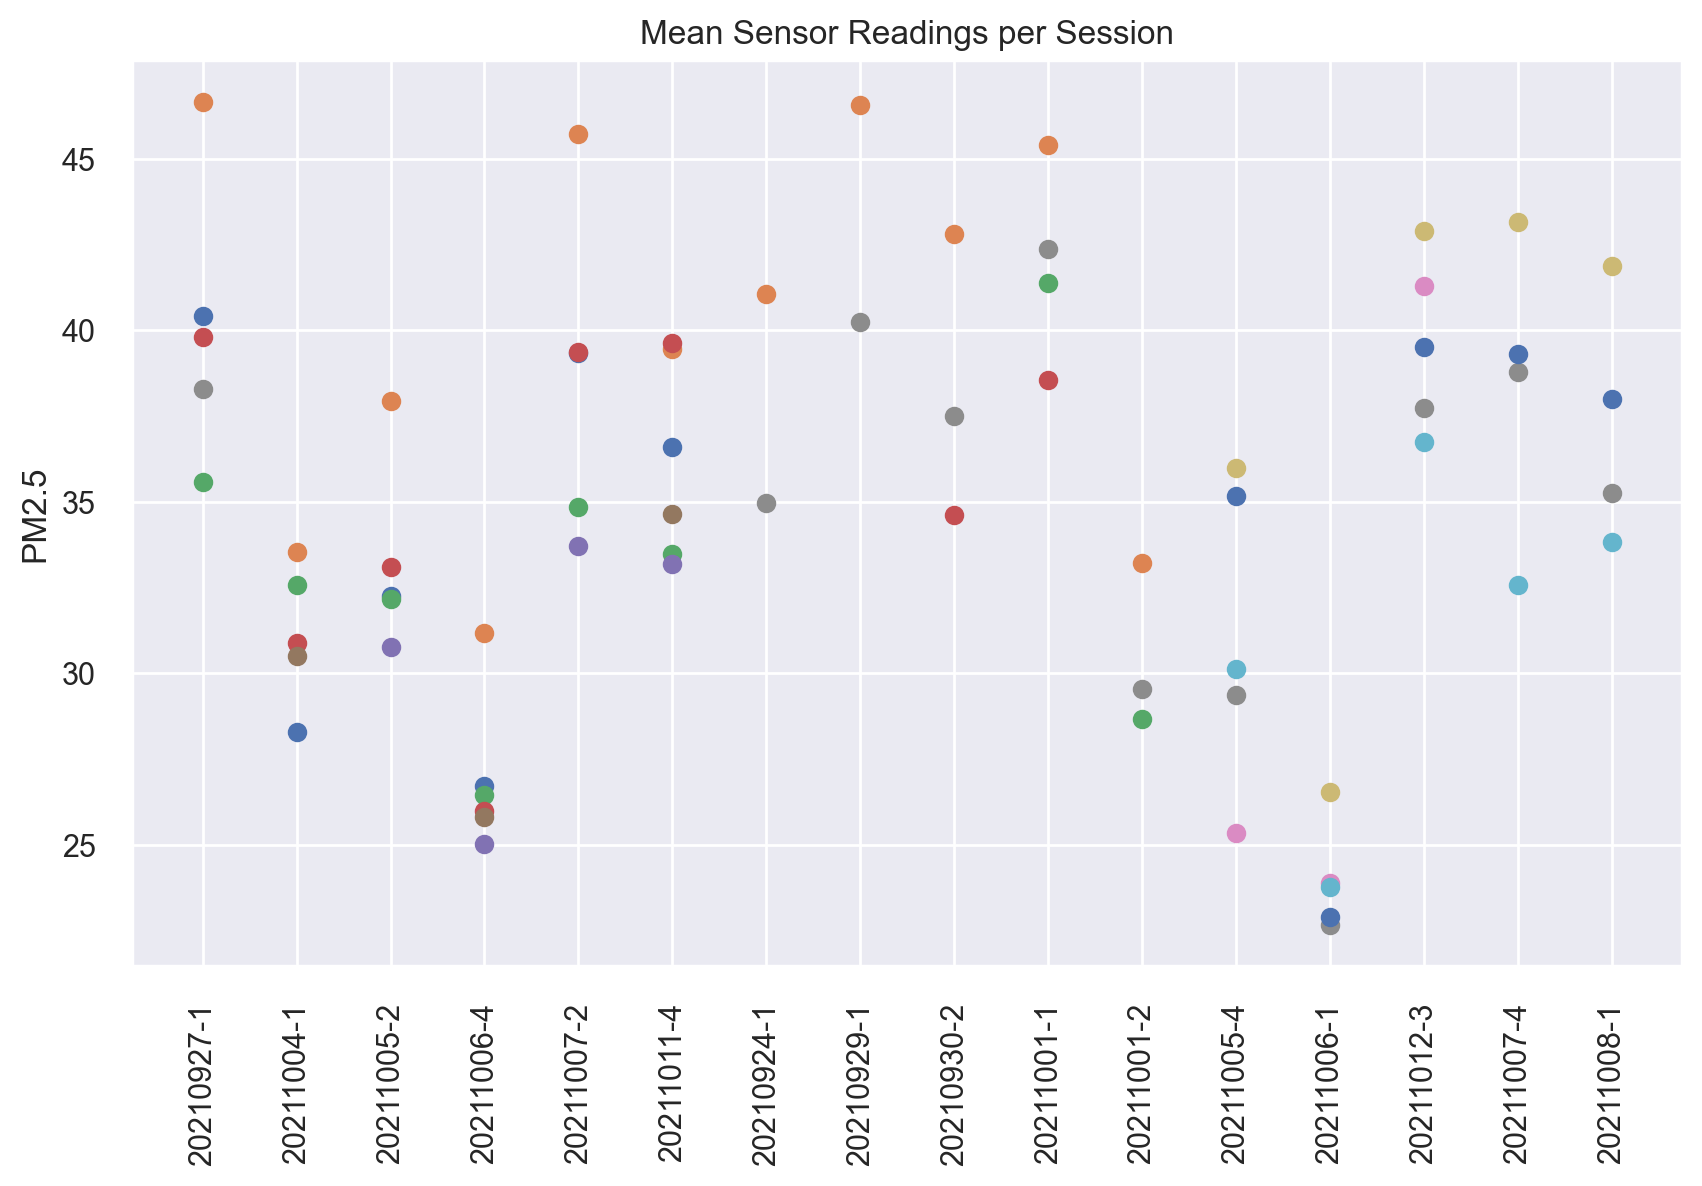

In [110]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

session_sensors = {}
for sensor, grp in focus_r_df.groupby('Sensor'):
    if sensor not in session_sensors:
        session_sensors[sensor] = {}
        
    for session_id, session_grp in grp.groupby('Session Id'):
        session_sensors[sensor][session_id] = session_grp[param].mean()
        
for sensor, data in session_sensors.items():
    ax.scatter(data.keys(), data.values(), label=sensor)
    
plt.xticks(rotation=90)
#plt.legend()
plt.title('Mean Sensor Readings per Session')
plt.savefig(f'{fig_folder}/Hotorget_mean_sensor_reading_per_session({param}).pdf')
plt.ylabel(param)

plt.show()

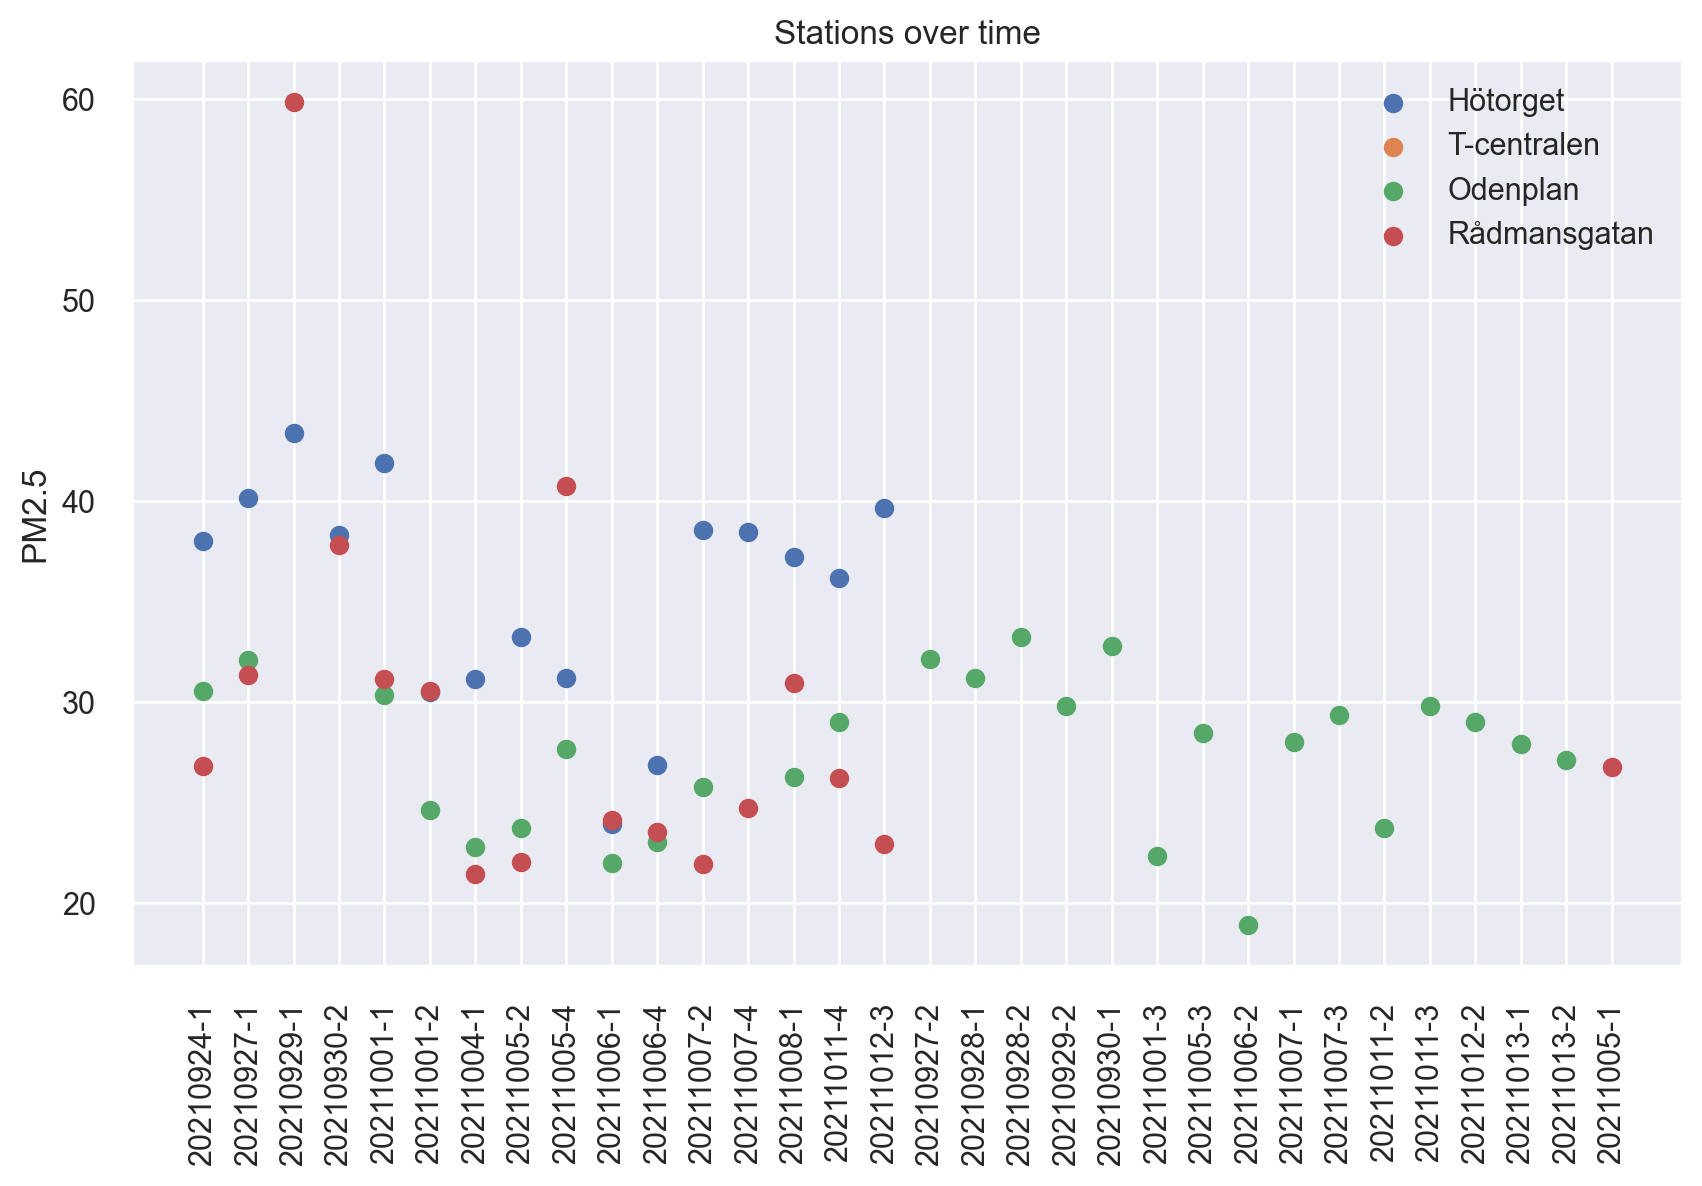

In [111]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

for station in ['Hötorget', 'T-centralen', 'Odenplan', 'Rådmansgatan']:
    session_means = {}
    for session, grp in r_df[r_df['Station'] == station].groupby('Session Id'):
        session_means[session] = grp[param].mean()

    ax.scatter(session_means.keys(), session_means.values(), label=station)
    
plt.xticks(rotation=90)
plt.legend()
#plt.legend()
plt.title('Stations over time')
plt.savefig(f'{fig_folder}/focus_dfs_over_time({param}).pdf')
plt.ylabel(param)

plt.show()

### Distribution

TypeError: skew() got an unexpected keyword argument 'bias'

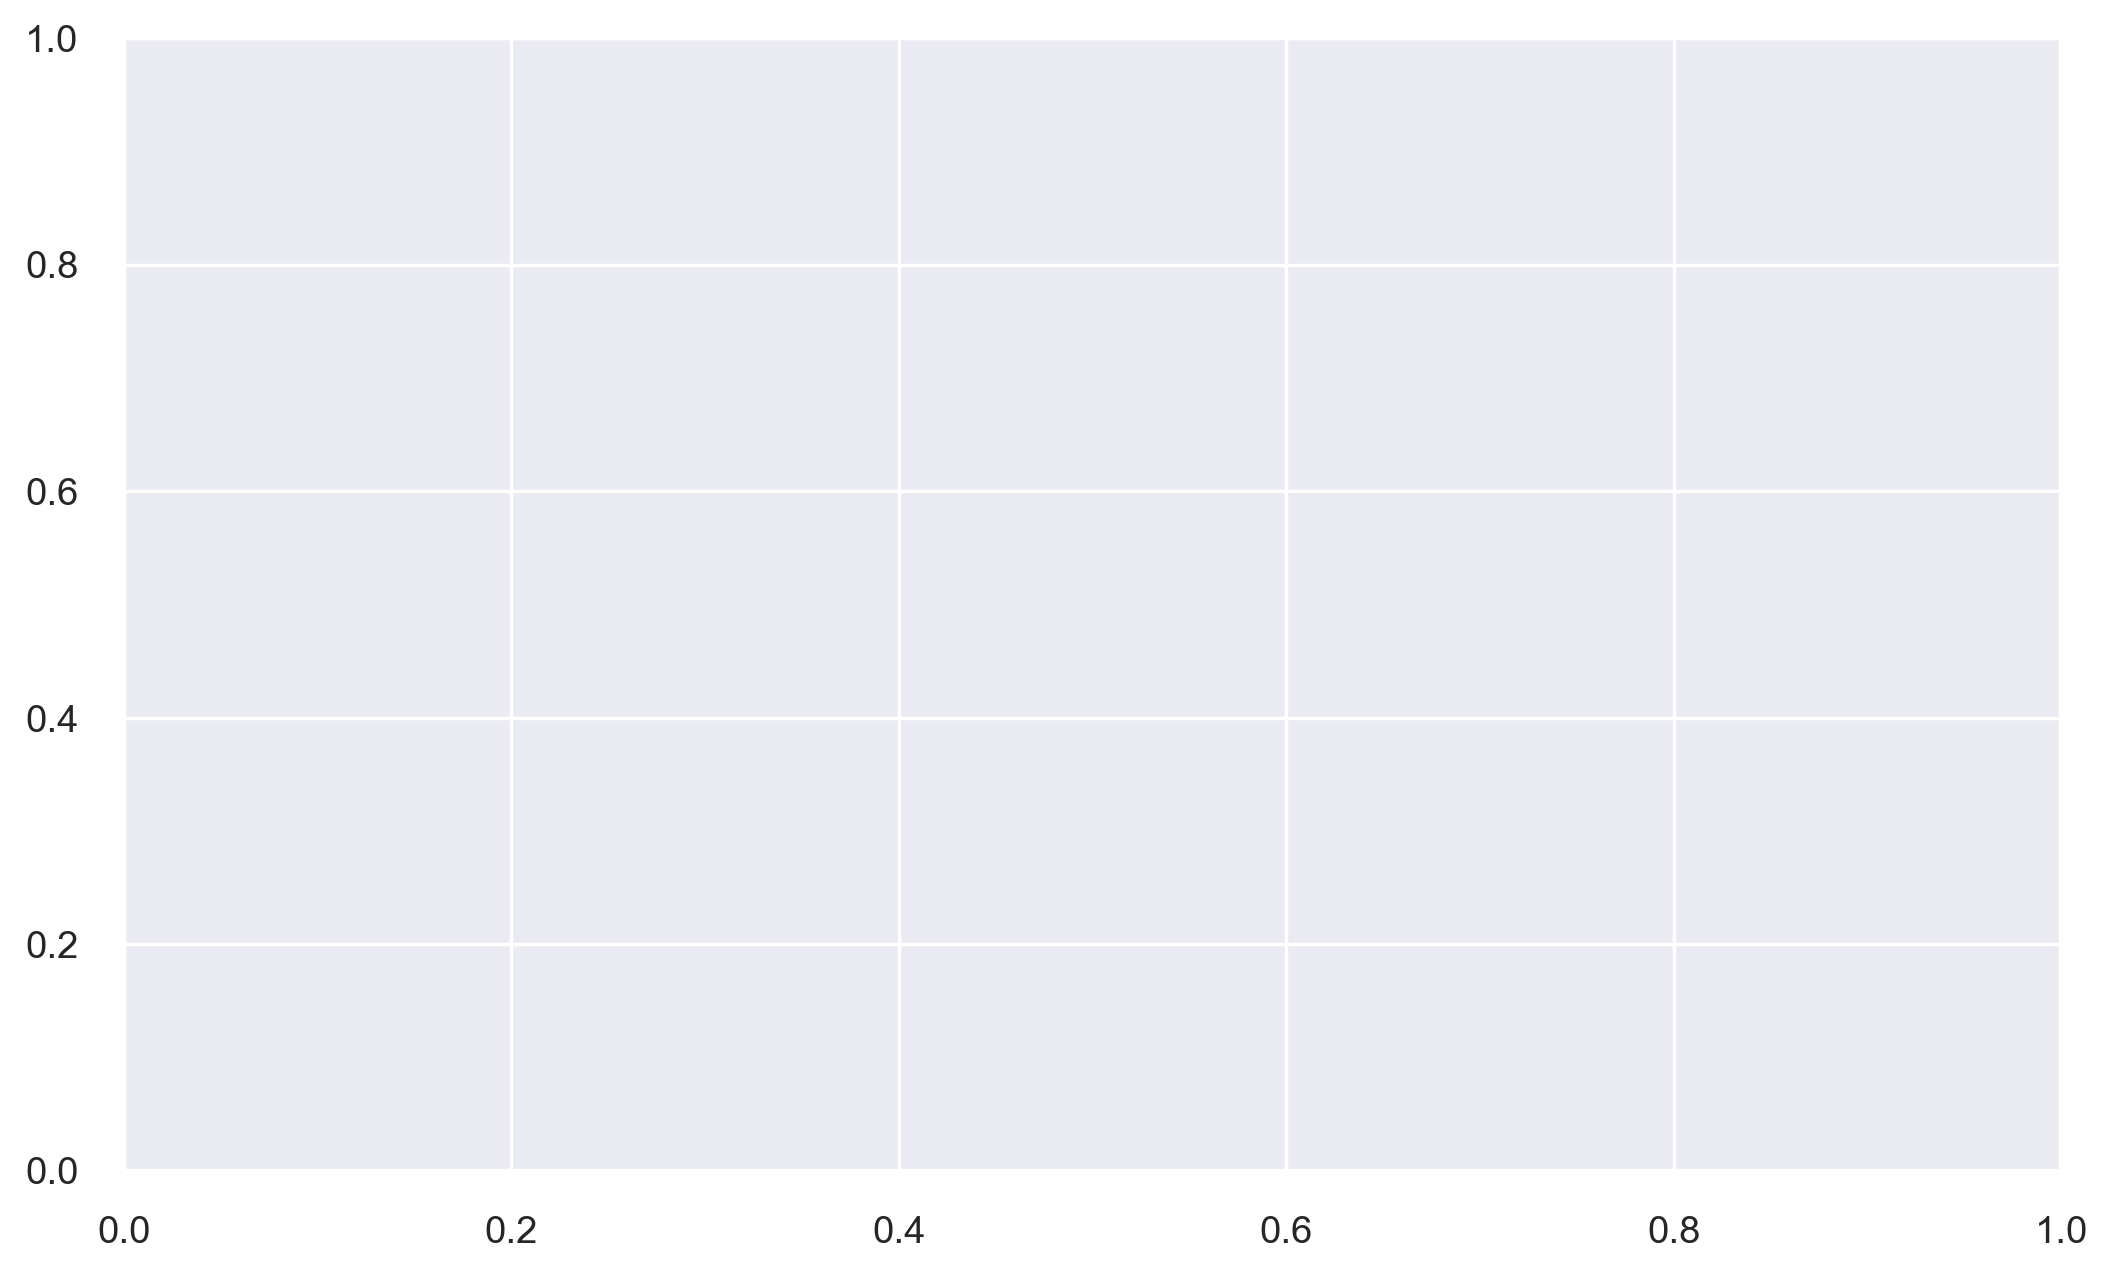

In [244]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = sample_std(focus_r_df[param].values)
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=20)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Hötorget Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/HotorgetDistribution({param}).pdf')

plt.show()

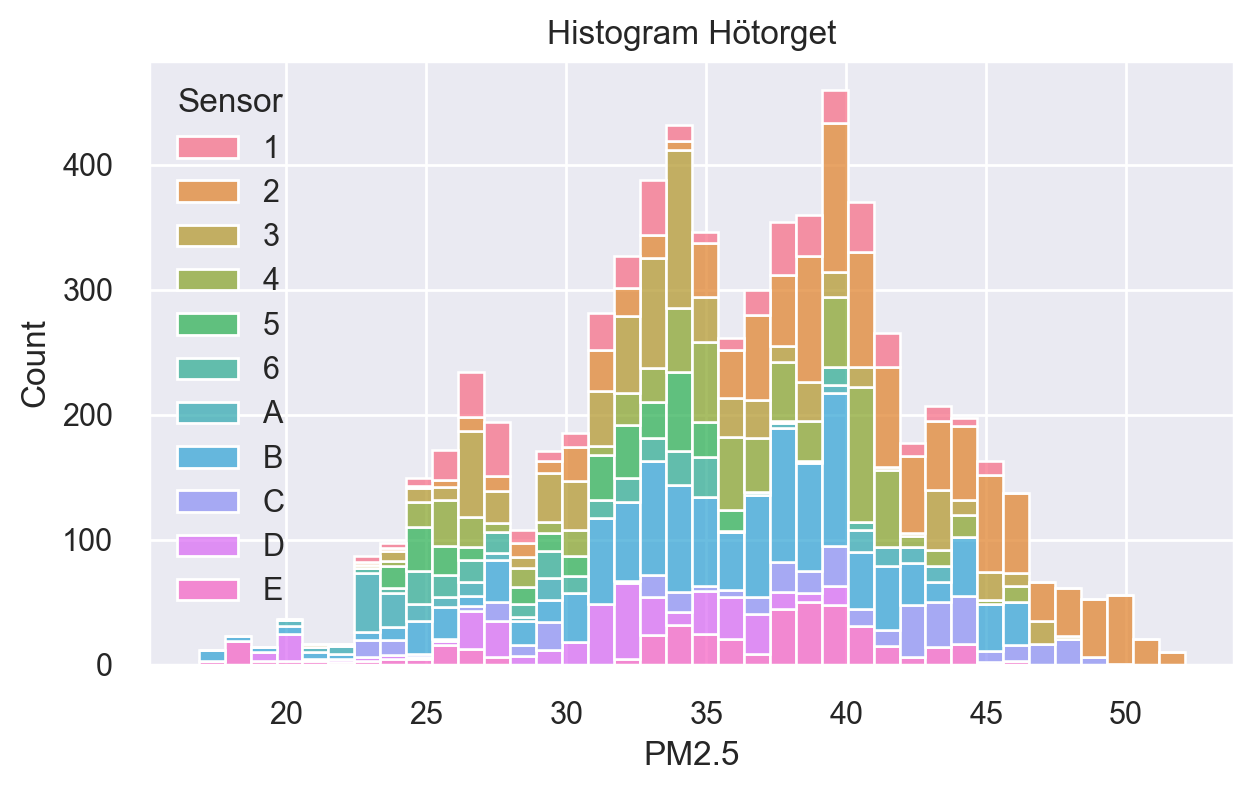

In [113]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', multiple='stack')
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HotorgetHistogram1Sensor({param}).pdf')

plt.show()

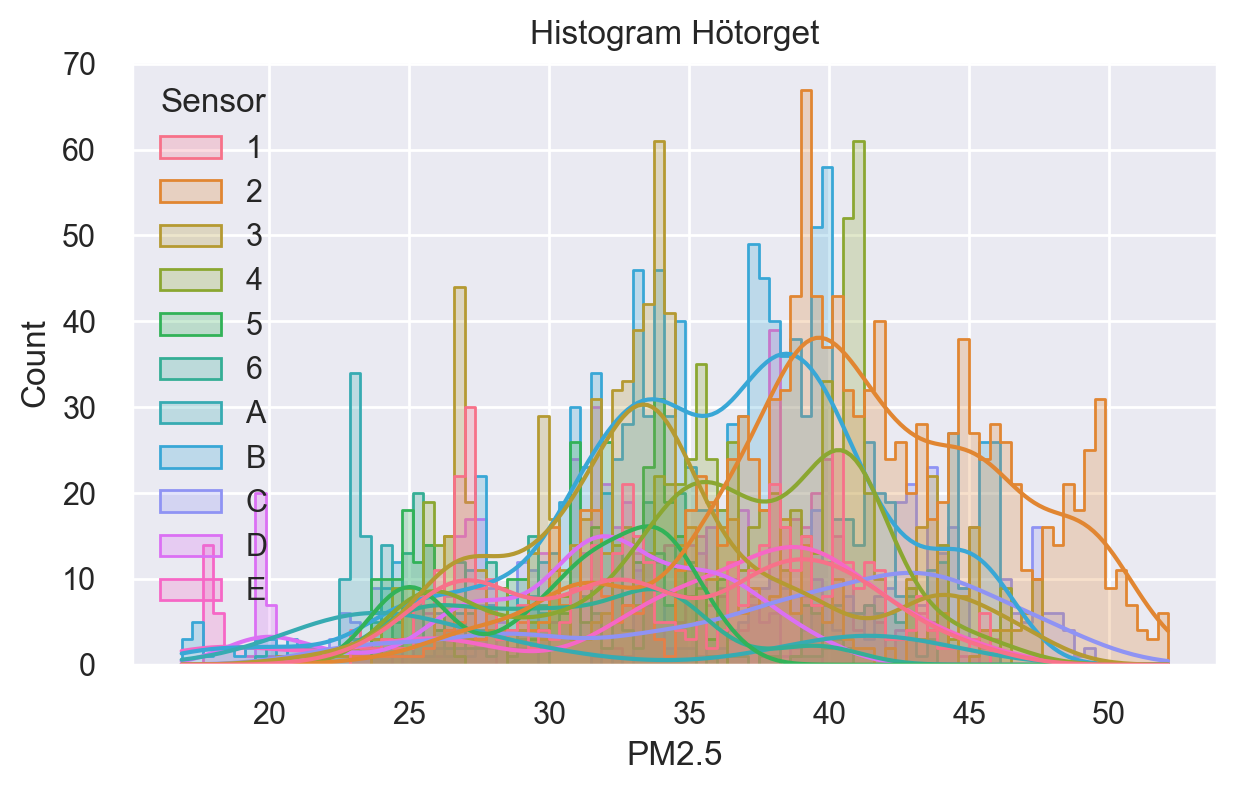

In [114]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(focus_r_df.sort_values(by=['Sensor']), x=param, hue='Sensor', kde=True, element='step', bins=94)
plt.title('Histogram Hötorget')

plt.savefig(f'{fig_folder}/HotorgetHistogram2Sensor({param}).pdf')

plt.show()

## ANOVA

In [115]:
anova_df = perform_ANOVA(
    focus_r_df,
    param=param,
    alpha=0.1,
)

anova_df.to_csv(f'{fig_folder}/tables/Hötorget_Anova({param}).csv')
anova_df

0
SST                              295047.814574
SSW                              227733.968812
SSB                               67313.845762
Alpha                                      0.1
F-stat                              200.935998
F-crit                                1.599657
P-value                                    0.0
F-stat > F-crit  True (Significant Difference)
p-value < alpha  True (Significant Difference)

In [116]:
# Anova per session
anovas = []

for session_id in focus_r_df['Session Id'].unique():
    anova_df = perform_ANOVA(
        focus_r_df[focus_r_df['Session Id'] == session_id],
        param=param,
        alpha=0.1,
    )
    
    anovas.append(anova_df)
    
anovas_df = pd.concat(anovas, axis=1)

anovas_df.to_csv(f'{fig_folder}/tables/Hötorget_Anovas({param}).csv')
anovas_df

0                              0  \
SST                               11530.251131                    8586.438319   
SSW                                4898.220966                    3572.376741   
SSB                                6632.030165                    5014.061578   
Alpha                                      0.1                            0.1   
F-stat                              165.522481                     201.271165   
F-crit                                1.956389                       1.855322   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                2960.138243                    8864.442191   
SSW                                 820.278864                    2975.903394   
SSB                                2139.859379                    5888.538797   
Alpha                                      0.1                            0.1   
F-stat                              227.608852                     160.772617   
F-crit                                1.961035                       1.962235   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                                  2691.2475                     4121.94123   
SSW                                 634.886053                    3051.142098   
SSB                                2056.361447                    1070.799133   
Alpha                                      0.1                            0.1   
F-stat                              329.724672                      27.900546   
F-crit                                1.858621                       1.962619   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                               10620.684802                    5142.162075   
SSW                                4716.667384                    3635.176491   
SSB                                5904.017418                    1506.985584   
Alpha                                      0.1                            0.1   
F-stat                              799.858634                      79.387546   
F-crit                                2.713405                       2.316484   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Difference)   

                                             0                              0  \
SST                               13605.374747                      2442.1313   
SSW                                8712.067149                      1124.0321   
SSB                                4893.307598                      1318.0992   
Alpha                                      0.1                            0.1   
F-stat                              151.276479                     152.444842   
F-crit                                2.090581                        2.74452   
P-value                                    0.0                            0.0   
F-stat > F-crit  True (Significant Difference)  True (Significant Difference)   
p-value < alpha  True (Significant Difference)  True (Significant Differ

### Tukey

In [117]:
tukey_df = focus_r_df[[param, 'Sensor']]

tukey = pairwise_tukeyhsd(
    endog=tukey_df[param],
    groups=tukey_df['Sensor'],
    alpha=0.1
)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.10 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   6.2782  0.001   5.3733  7.1832   True
     1      3  -0.2525    0.9  -1.2237  0.7187  False
     1      4   1.7434  0.001   0.7576  2.7292   True
     1      5  -3.5892  0.001  -4.7928 -2.3856   True
     1      6  -3.4936  0.001  -4.7912 -2.1959   True
     1      A  -4.3594  0.001   -5.756 -2.9628   True
     1      B   1.3455  0.001   0.4425  2.2485   True
     1      C   4.1984  0.001   3.0634  5.3334   True
     1      D  -2.8902  0.001  -4.0259 -1.7545   True
     1      E   0.9564 0.2954  -0.1757  2.0885  False
     2      3  -6.5308  0.001  -7.2973 -5.7643   True
     2      4  -4.5349  0.001  -5.3198 -3.7499   True
     2      5  -9.8674  0.001 -10.9129  -8.822   True
     2      6  -9.7718  0.001 -10.9243 -8.6193   True
     2      A -10.6377  0.001 -11.9005 -9.3748   True
     2      B  -4.9328  0.00

In [118]:
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

tukey_df.to_csv(f'{fig_folder}/tables/Hötorget_Tukey({param}).csv')

## Systematic Error

How much would the sensors need to be wrong to get the value of 35?

In [119]:
h_mean = focus_s_df[param].mean()
h_std = sample_std(focus_s_df[param].values)

print(f'{round(h_mean, 2)}±{round(h_std, 2)}')

35.55±5.5


In [120]:
# If sensors measure 5microgram per cubic meter
# According to datasheet - ±10 units
# 5 --> max 15 (need to differ with 30.5 units --> 3 times more than datasheet (increase 200%))
# 15 --> max 25 (need to differ with 20.5 units --> 2 times more than datasheet (increase 100%))

# Min value with std: 30.11, still 5 units over

In [121]:
round(h_mean - h_std, 2)

30.05

In [122]:
# 5 barrier
increase = h_mean - 5
prcnt = increase / 10

print(increase)
print(prcnt)

30.551593736349915
3.0551593736349916


In [123]:
# 15 barrier
increase = h_mean - 15
prcnt = increase / 10

print(increase)
print(prcnt)

20.551593736349915
2.0551593736349916


In [124]:
h_mean - 5

30.551593736349915

### Comparison with aboveground measurements

One explanation: a lot of traffic above

# Size Distributions
How much do the size for the different sensors distribute themselves?

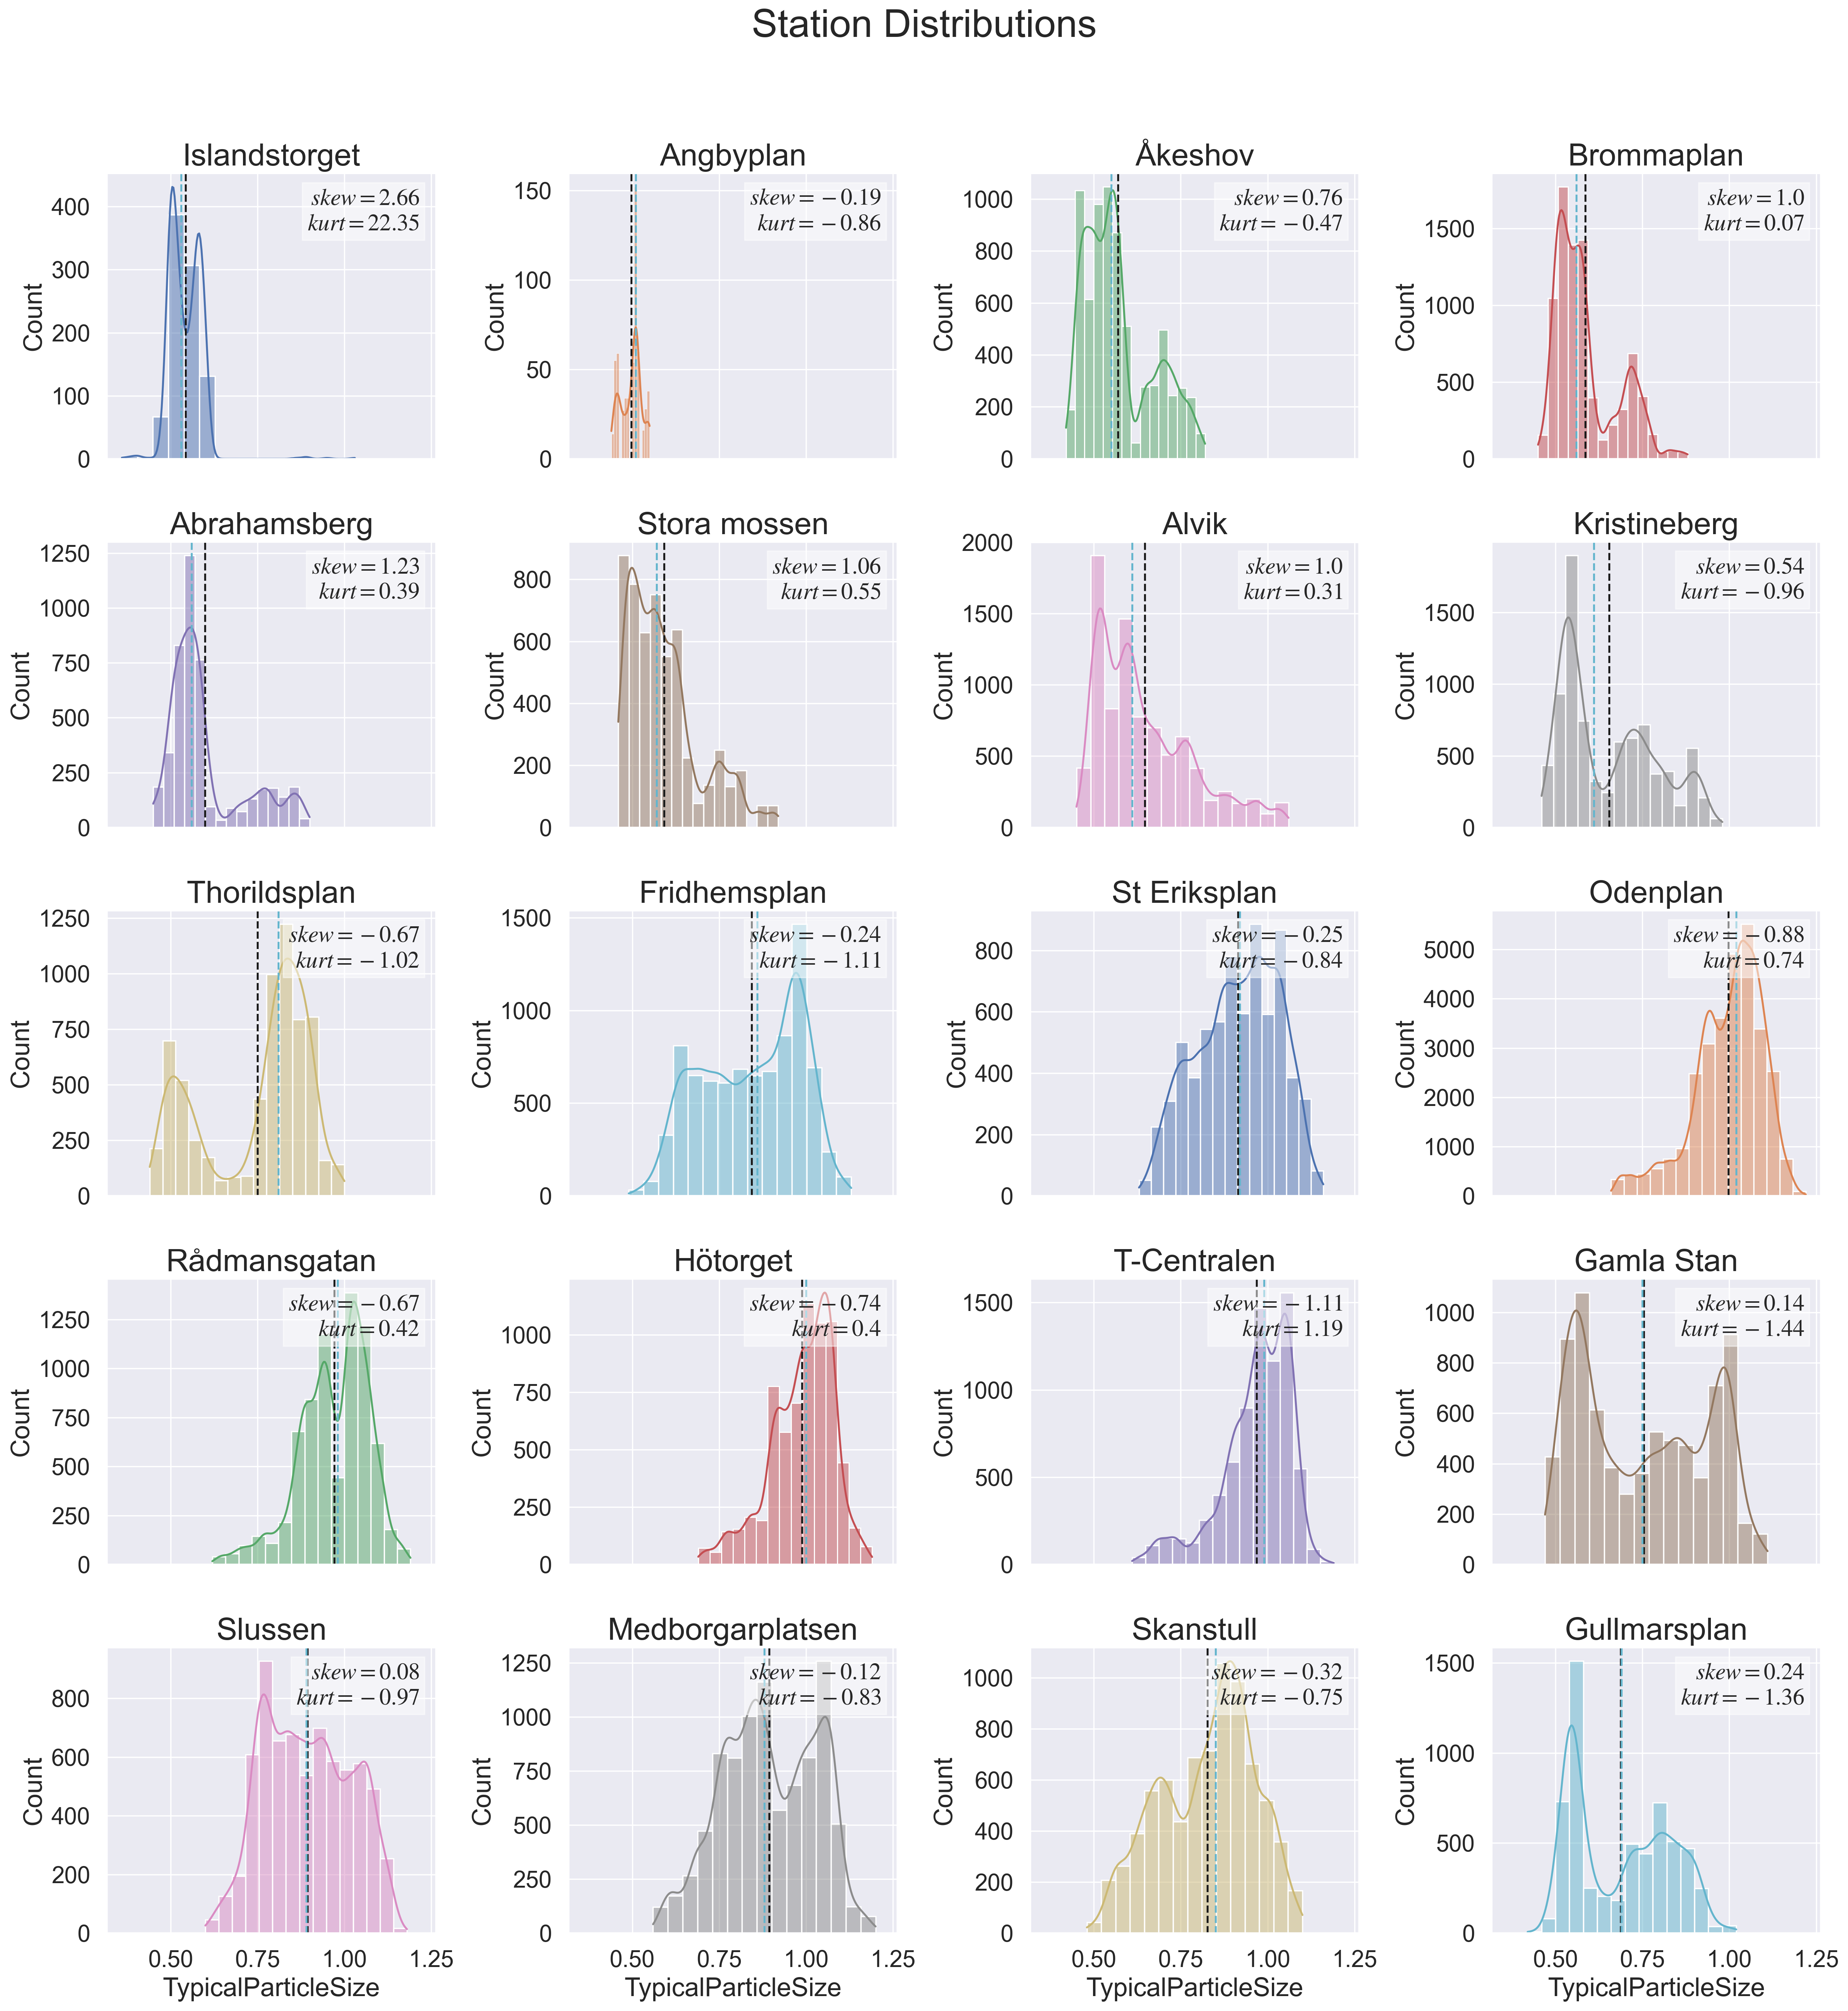

In [247]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/typical_particle_size_distribution({param}).pdf',
    param='TypicalParticleSize',
    with_textbox=True,
    column_count=4,
    bins=15,
    share_x=True
)

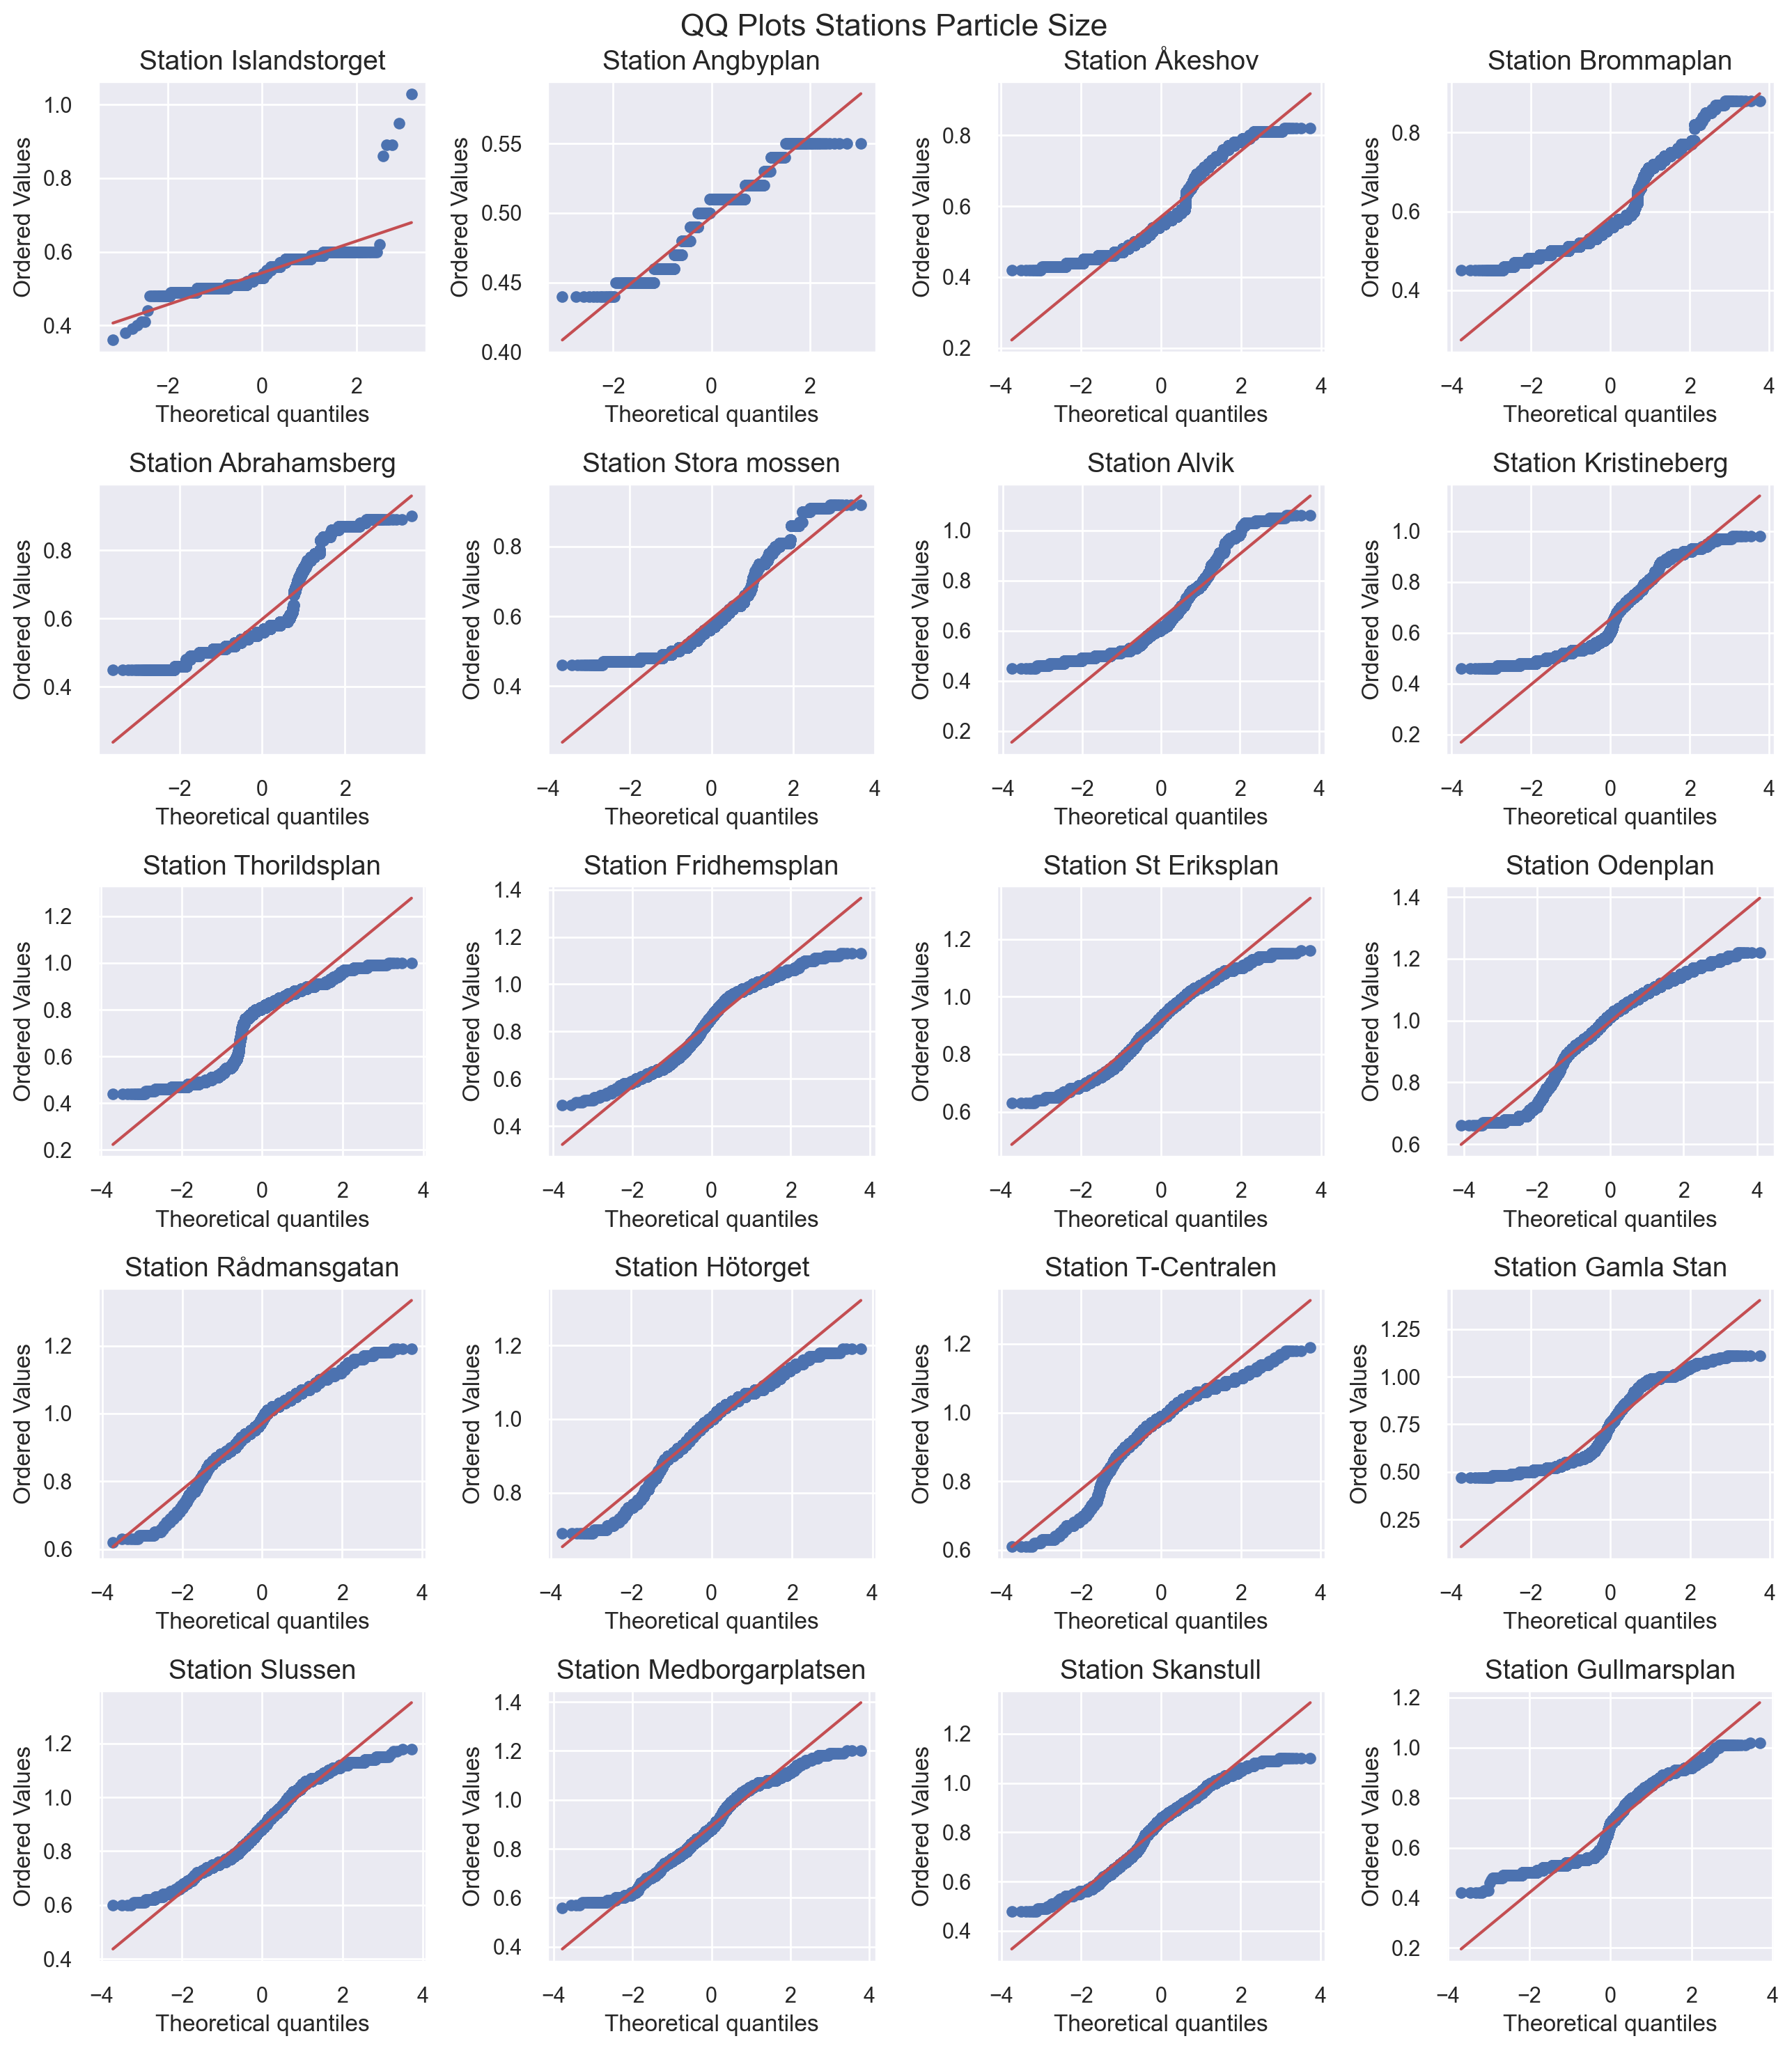

In [248]:
plot_QQ_plots(
    r_df, 
    title='QQ Plots Stations Particle Size', 
    param='TypicalParticleSize', 
    fig_name=f'{fig_folder}/QQPlots(typical_particle_size).pdf',
    col_count=4,
    row_count=5,
    label='Station',
    size=(13, 15)
)

In [ ]:
### Compare NC0.5-NC1.0, NC1.0-NC2.5, NC2.5-NC4.0, NC4.0-NC10

station = 'Kristineberg'



# Correlation Heat Map

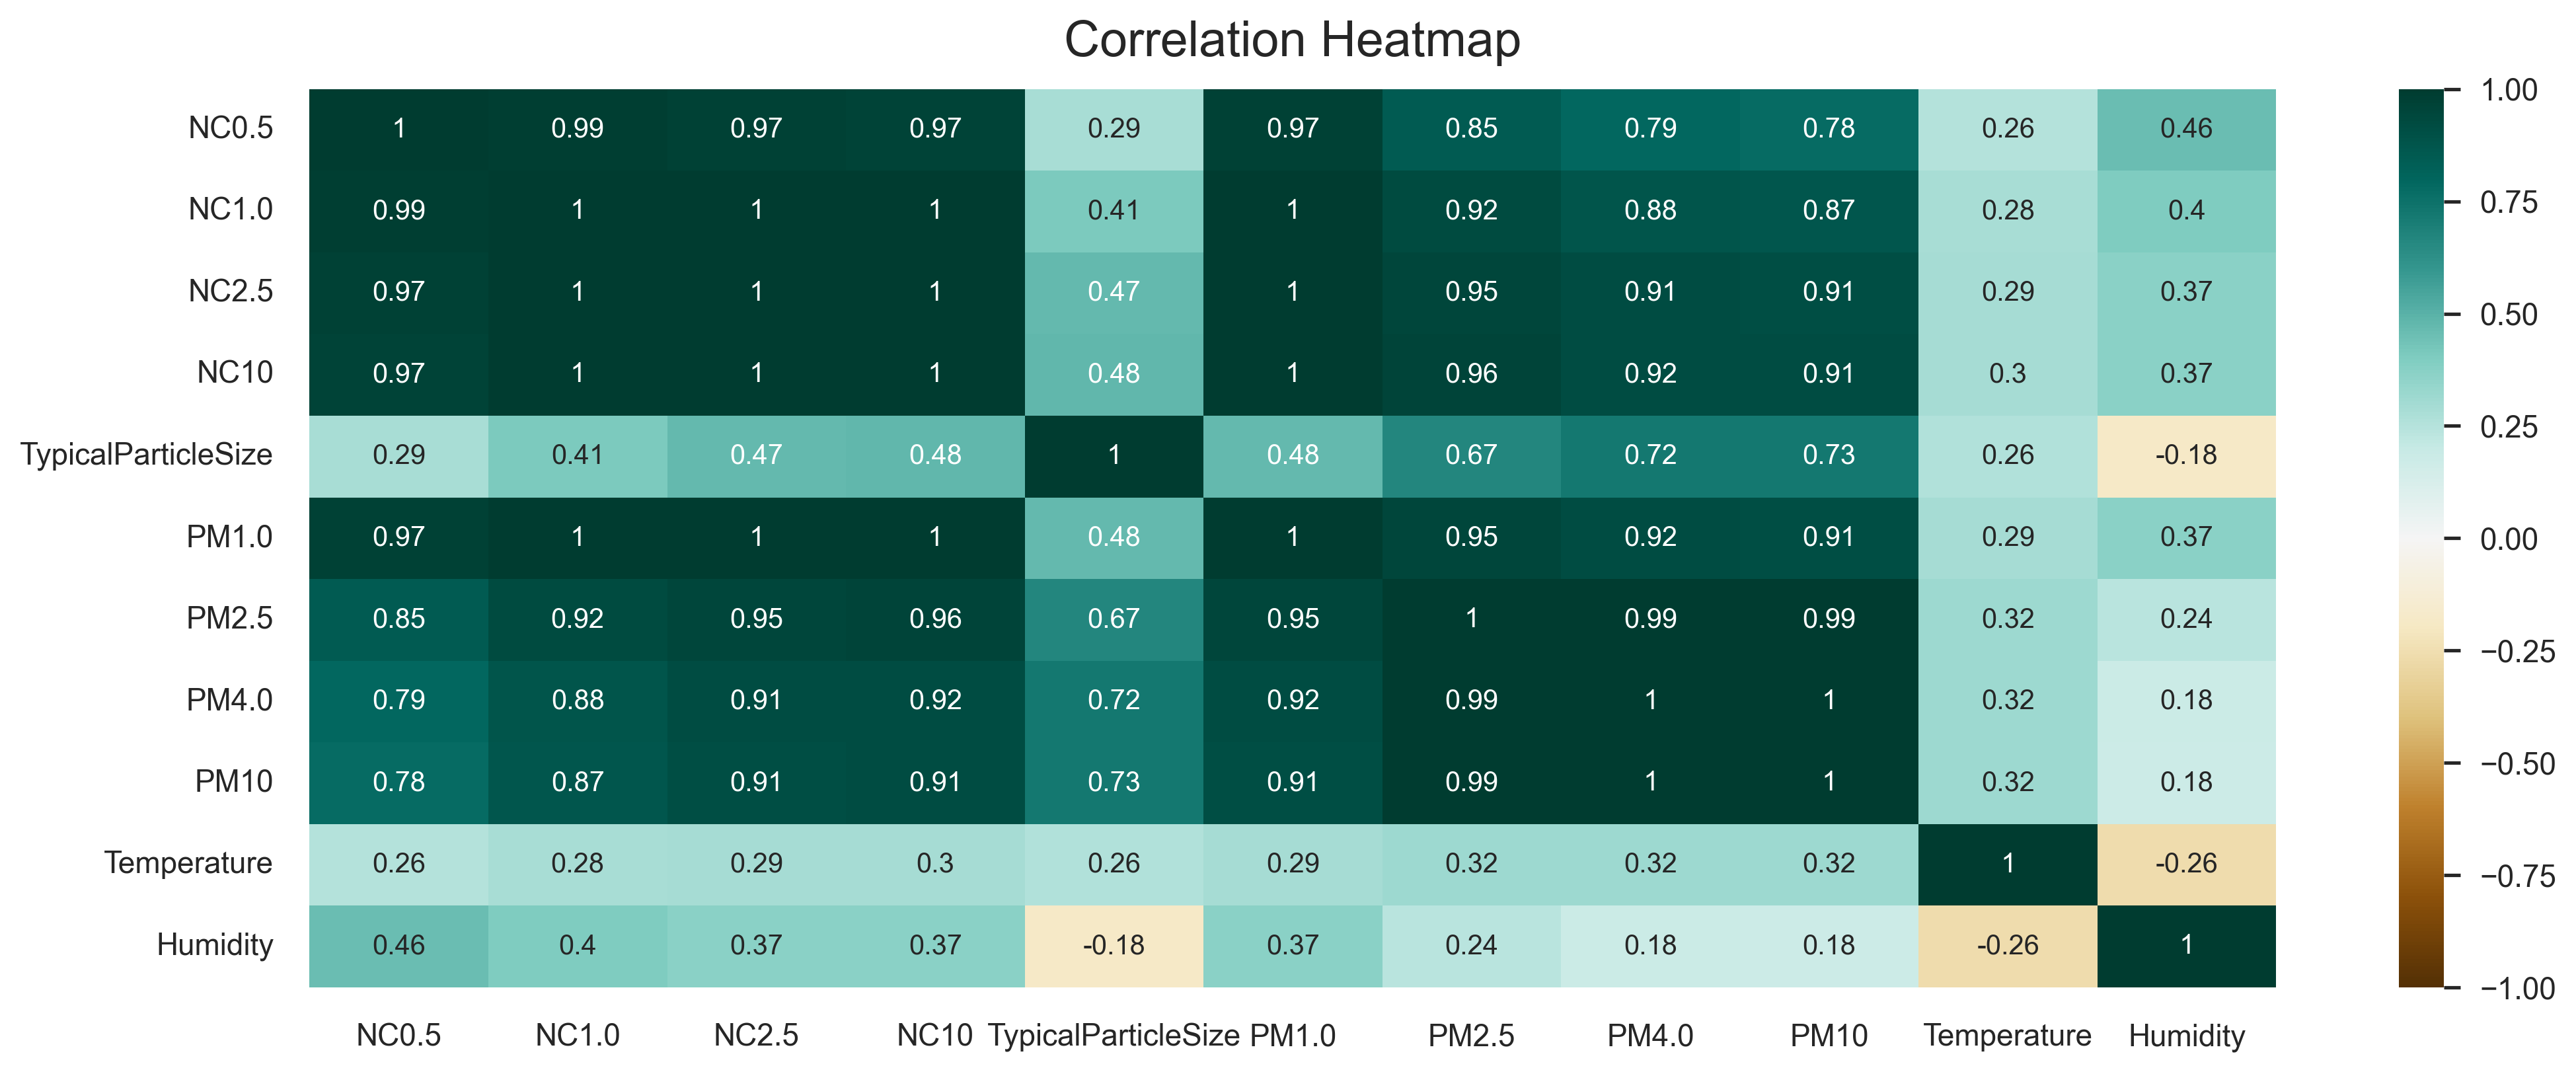

In [261]:
plt.figure(figsize=(16, 6), dpi=300)

heatmap = sns.heatmap(s_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig(f'{fig_folder}/heatmap.pdf', dpi=300, bbox_inches='tight')

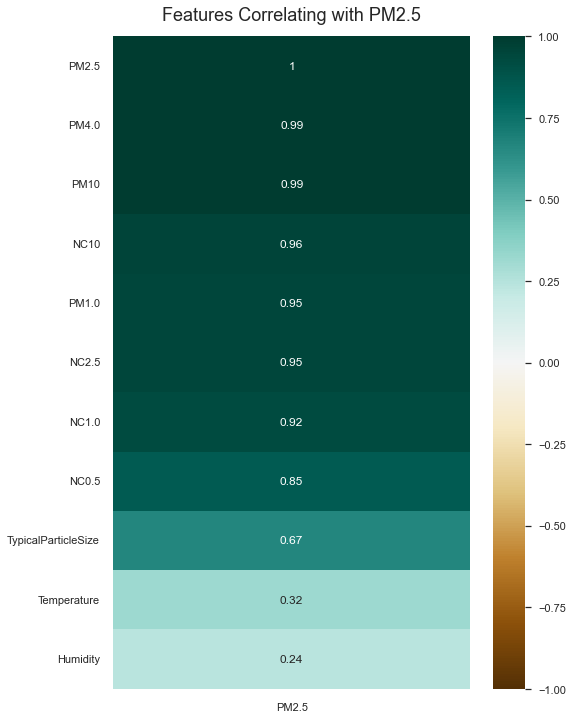

In [272]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(s_df.corr()[[param]].sort_values(by=param, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Features Correlating with {param}', fontdict={'fontsize':18}, pad=16);

plt.savefig(f'{fig_folder}/heatmap({param}).pdf', dpi=300, bbox_inches='tight')
